In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.path as mpath
from astropy.io import fits
from astropy.visualization.mpl_normalize import simple_norm
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update({
    'text.usetex': False,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.family': 'serif',
    'font.weight': 'normal',
    'figure.facecolor': 'lightgray',
    'mathtext.fontset': 'dejavuserif'
})

# $\text{Tarea 1 Astrofísica Extragaláctica}$

$\text{Marcelo Nicolás Ojeda Cárdenas}$

## $\text{Problema 1: Medición de distancias}$

### $\text{a)}$ 

Primero, utilizando la función ```SkyCoord``` de la librería ```astropy.coordinates```, encontraremos las coordenadas de ra y dec en grados del cúmulo globular NGC 5904.

In [3]:
ngc_5904_coordinates = SkyCoord.from_name('NGC 5904')
ngc_5904_coordinates

<SkyCoord (ICRS): (ra, dec) in deg
    (229.638417, 2.081028)>

Utilizando estas coordenadas, haremos el siguiente query en la base de datos de GAIA.

```sql
SELECT TOP 40000 *
FROM gaiadr3.gaia_source
WHERE 1 = CONTAINS(POINT(229.6384, 2.0810), CIRCLE(ra, dec, 1))
AND phot_g_mean_mag < 18
```

Este query selecciona todas las estrellas que se encuentran en un radio de 1 grado centrado en el cúmulo NGC 5904 y que tengan magnitudes menores a 18 mag, con un tope de 40000 estrellas. Una vez descargados los datos en un archivo .csv, lo cargaremos en un DataFrame de ```pandas``` para el resto del análisis.

In [4]:
ngc_5904_path = 'ngc5904-query5.csv'
ngc_5904 = pd.read_csv(ngc_5904_path)
ngc_5904.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 4421576266097389952,4421576266097389952,378472974,2016.0,229.924897,0.064704,2.129076,0.057437,0.636456,...,0.0223,0.0060,0.0477,0.0178,0.0048,0.0382,0.0095,0.0025,0.0204,PHOENIX
1,1636148068921376768,Gaia DR3 4421576300457139840,4421576300457139840,1335052809,2016.0,229.940683,0.102193,2.134072,0.092044,-0.087390,...,0.0043,0.0011,0.0117,0.0036,0.0010,0.0099,0.0020,0.0005,0.0055,MARCS
2,1636148068921376768,Gaia DR3 4421576304757248256,4421576304757248256,29552863,2016.0,229.942215,0.098585,2.135823,0.089222,0.206983,...,0.0049,0.0011,0.0135,0.0041,0.0010,0.0114,0.0023,0.0005,0.0063,MARCS
3,1636148068921376768,Gaia DR3 4421576403536346752,4421576403536346752,181015970,2016.0,229.890954,0.088095,2.130741,0.084303,0.553336,...,0.0030,0.0007,0.0086,0.0023,0.0005,0.0066,0.0012,0.0002,0.0035,PHOENIX
4,1636148068921376768,Gaia DR3 4421576575335121280,4421576575335121280,1655726642,2016.0,229.921763,0.076517,2.163223,0.067773,0.090320,...,0.0128,0.0034,0.0400,0.0105,0.0028,0.0330,0.0057,0.0015,0.0180,MARCS


In [5]:
for col in ngc_5904.columns:
    print(col)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

Realizaremos un scatter plot de ra vs dec para observar la distribución de las estrellas en el cúmulo.

Text(0.5, 1.0, 'NGC 5904')

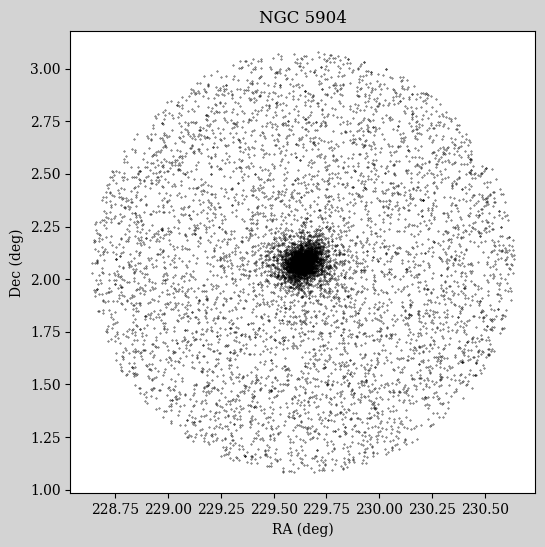

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(ngc_5904['ra'], ngc_5904['dec'], s=0.1, color='black')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('NGC 5904')

### $\text{b)}$

Haremos un gráfico de densidad del movimiento propio de las estrellas en el cúmulo. Utilizaremos ```jointplot``` de la librería ```seaborne```, que nos permite realizar un gráfico de densidad que además muestra histogramas para cada eje dado.

<Figure size 500x500 with 0 Axes>

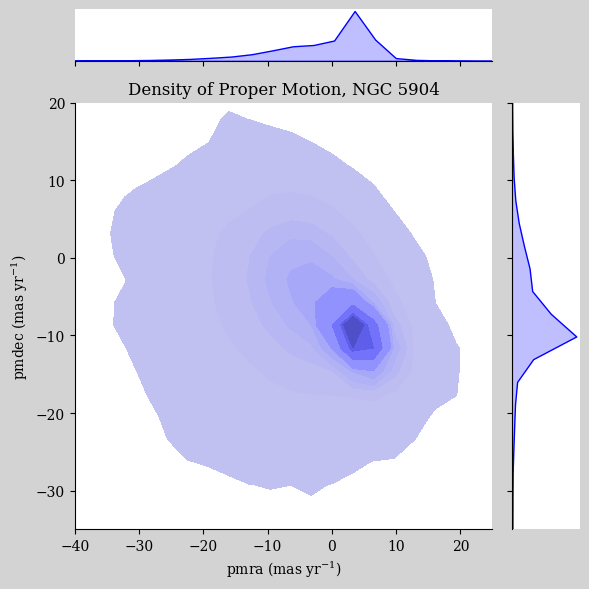

In [7]:
plt.figure(figsize=(5, 5))

sns_plot = sns.jointplot(data=ngc_5904, x='pmra', y='pmdec', kind='kde', color='blue', fill=True, height=6)

ax_joint = sns_plot.ax_joint
ax_joint.set_xlim(-40, 25)
ax_joint.set_ylim(-35, 20)

ax_joint.set_xlabel(r'pmra (mas yr$^{-1}$)')
ax_joint.set_ylabel(r'pmdec (mas yr$^{-1}$)')

ax_joint.set_title('Density of Proper Motion, NGC 5904')

plt.tight_layout()

Observamos que hay una región de mayor densidad en el movimiento propio, lo que podemos interpretar como que existe un grupo de estrellas que comparten el mismo movimiento. Este grupo de estrellas son las que pertenecen al cúmulo NGC 5904.

Para poder aislar estas estrellas, podemos analizar la distribución de datos de pmra y pmdec por separado, utilizando histogramas para ello.

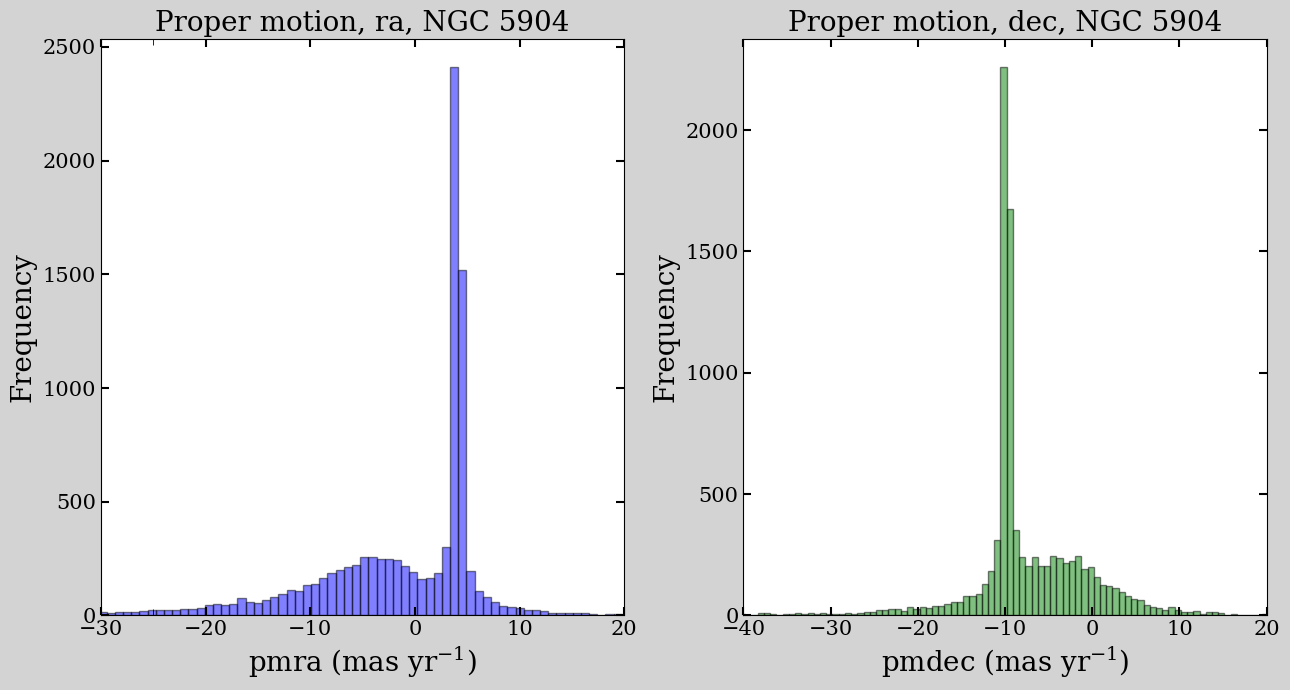

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.hist(ngc_5904['pmra'], bins=800, color='blue', alpha=0.5, edgecolor='black')

ax1.set_xlim(-30, 20)

ax1.set_ylabel(r'Frequency', fontsize=20)
ax1.set_xlabel(r"pmra (mas yr$^{-1}$)", fontsize=20)
ax1.set_title(r'Proper motion, ra, NGC 5904', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(2500))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax1.grid(False, which='both')

ax2.hist(ngc_5904['pmdec'], bins=800, color='green', alpha=0.5, edgecolor='black')

ax2.set_xlim(-40, 20)

ax2.set_ylabel(r'Frequency', fontsize=20)
ax2.set_xlabel(r"pmdec (mas yr$^{-1}$)", fontsize=20)
ax2.set_title(r'Proper motion, dec, NGC 5904', fontsize=20)

ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5000))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax2.grid(False, which='both')

plt.tight_layout()

Vemos que, para ambos parámetros, las distribuciones se caracterizan por presentar dos distribuciones gaussianas, donde se observa claramente una gaussiana con un peak mayor, que es donde se encuentran la mayoría de estrellas de la distribución con ese determinado valor de pmra o pmdec. Podemos aislar este peak realizando un ajuste gaussiano, y en base a los resultados, eliminar todos los datos que se encuentren fuera de esta distribución dado un sigma conveniente.

In [9]:
pmra_data = ngc_5904['pmra'].dropna()

# Calculamos el histograma eligiendo 800 bins
bin_count_ra = 800
hist_ra, bin_edges_ra = np.histogram(pmra_data, bins=bin_count_ra, density=False)
bin_centers_ra = (bin_edges_ra[:-1] + bin_edges_ra[1:]) / 2

# Utilizar un kernel Gaussiano para convolucionar el histograma y suavizarlo
gaussian_kernel_ra = Gaussian1DKernel(stddev=1.5)  # Elegimos sigma 1.5, arbitrario pero conveniente
smoothed_hist_ra = convolve(hist_ra, gaussian_kernel_ra)

# Ajustamos una Gaussiana al histograma suavizado
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Calculamos el promedio ponderado y la desviación estándar para el histograma
weighted_mean_ra = np.sum(bin_centers_ra * hist_ra) / np.sum(hist_ra)
weighted_std = np.sqrt(np.sum(hist_ra * (bin_centers_ra - weighted_mean_ra) ** 2) / np.sum(hist_ra))

# Usamos estos valores como priors
initial_guess_ra = [max(hist_ra), weighted_mean_ra, weighted_std]

# Hacemos el ajuste utilizando curve_fit
params_ra, _ = curve_fit(gaussian, bin_centers_ra, smoothed_hist_ra, p0=initial_guess_ra)

# ---------------------------

# Repetimos el mismo proceso para pmdec

pmdec_data = ngc_5904['pmdec'].dropna()

bin_count_dec = 800
hist_dec, bin_edges_dec = np.histogram(pmdec_data, bins=bin_count_dec, density=False)
bin_centers_dec = (bin_edges_dec[:-1] + bin_edges_dec[1:]) / 2

gaussian_kernel_dec = Gaussian1DKernel(stddev=1.5) 
smoothed_hist_dec = convolve(hist_dec, gaussian_kernel_dec)

weighted_mean_dec = np.sum(bin_centers_dec * hist_dec) / np.sum(hist_dec)
weighted_std = np.sqrt(np.sum(hist_dec * (bin_centers_dec - weighted_mean_dec)**2) / np.sum(hist_dec))

initial_guess_dec = [max(hist_dec), weighted_mean_dec, weighted_std]

params_dec, _ = curve_fit(gaussian, bin_centers_dec, smoothed_hist_dec, p0=initial_guess_dec)

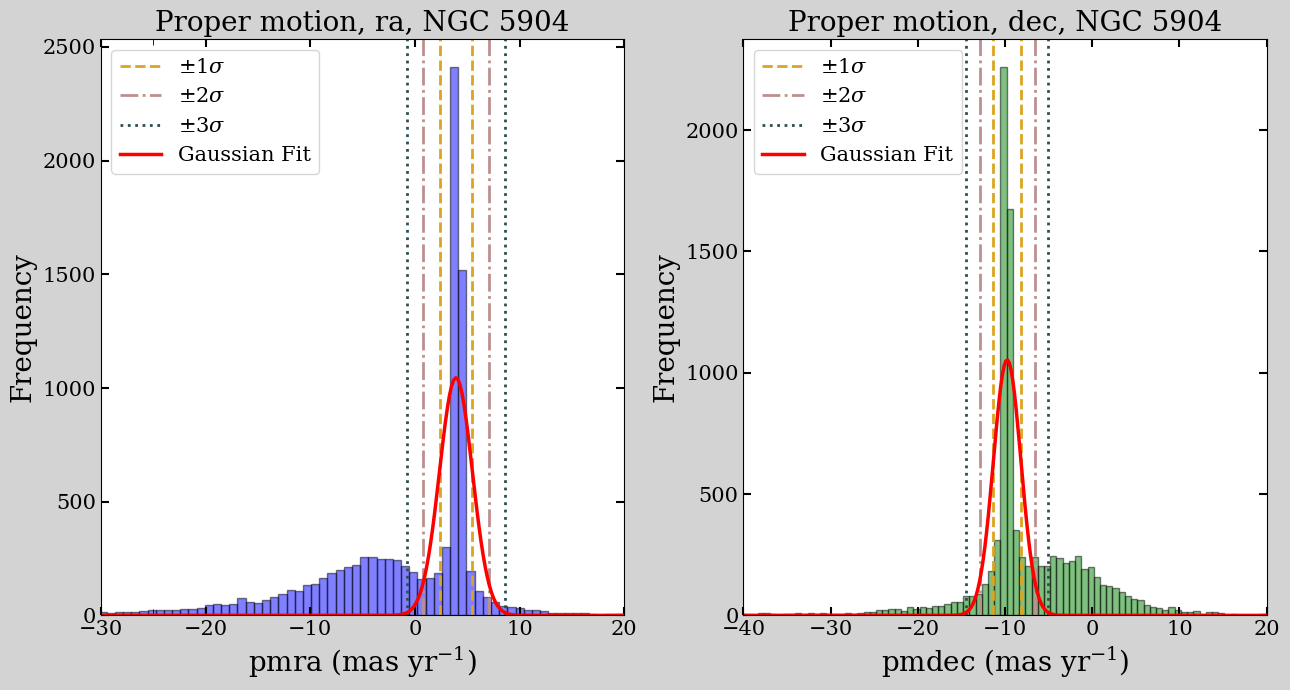

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.hist(ngc_5904['pmra'], bins=800, color='blue', alpha=0.5, edgecolor='black')

# Añadimos líneas verticales para 1, 2 y 3 sigma
sigma = params_ra[2]
ax1.axvline(params_ra[1] + sigma, color='goldenrod', linestyle='--', label=r'$\pm 1 \sigma$', linewidth=2)
ax1.axvline(params_ra[1] - sigma, color='goldenrod', linestyle='--', linewidth=2)
ax1.axvline(params_ra[1] + 2*sigma, color='rosybrown', linestyle='-.', label=r'$\pm 2 \sigma$', linewidth=2)
ax1.axvline(params_ra[1] - 2*sigma, color='rosybrown', linestyle='-.', linewidth=2)
ax1.axvline(params_ra[1] + 3*sigma, color='darkslategray', linestyle=':', label=r'$\pm 3 \sigma$', linewidth=2)
ax1.axvline(params_ra[1] - 3*sigma, color='darkslategray', linestyle=':', linewidth=2)

ax1.plot(np.linspace(-100, 100, 1000), gaussian(np.linspace(-100, 100, 1000), *params_ra), color='red', label='Gaussian Fit', linewidth=2.5)

ax1.set_xlim(-30, 20)

ax1.set_ylabel(r'Frequency', fontsize=20)
ax1.set_xlabel(r"pmra (mas yr$^{-1}$)", fontsize=20)
ax1.set_title(r'Proper motion, ra, NGC 5904', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(2500))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax1.grid(False, which='both')
ax1.legend(fontsize=15, markerscale=1)

ax2.hist(ngc_5904['pmdec'], bins=800, color='green', alpha=0.5, edgecolor='black')

sigma = params_dec[2]
ax2.axvline(params_dec[1] + sigma, color='goldenrod', linestyle='--', label=r'$\pm 1 \sigma$', linewidth=2)
ax2.axvline(params_dec[1] - sigma, color='goldenrod', linestyle='--', linewidth=2)
ax2.axvline(params_dec[1] + 2*sigma, color='rosybrown', linestyle='-.', label=r'$\pm 2 \sigma$', linewidth=2)
ax2.axvline(params_dec[1] - 2*sigma, color='rosybrown', linestyle='-.', linewidth=2)
ax2.axvline(params_dec[1] + 3*sigma, color='darkslategray', linestyle=':', label=r'$\pm 3 \sigma$', linewidth=2)
ax2.axvline(params_dec[1] - 3*sigma, color='darkslategray', linestyle=':', linewidth=2)

ax2.plot(np.linspace(-100, 100, 1000), gaussian(np.linspace(-100, 100, 1000), *params_dec), color='red', label='Gaussian Fit', linewidth=2.5)

ax2.set_xlim(-40, 20)

ax2.set_ylabel(r'Frequency', fontsize=20)
ax2.set_xlabel(r"pmdec (mas yr$^{-1}$)", fontsize=20)
ax2.set_title(r'Proper motion, dec, NGC 5904', fontsize=20)

ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5000))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax2.grid(False, which='both')
ax2.legend(fontsize=15, markerscale=1)

# space between plots
plt.tight_layout()

Una vez realizado el ajuste gaussiano para la distribución, notamos que una buena elección para poder filtrar la mayoría de los datos pertenecientes al cúmulo es eliminar todos los datos que se encuentren a una desviación estándar del promedio, tanto para los datos en ra como para dec.

In [11]:
# Creamos un nuevo dataset para el cúmulo, eliminando valores de pmra y pmdec values que estén sobre o bajo 1 sigma.
ngc_5904_clipped = ngc_5904[(ngc_5904['pmra'] > params_ra[1] - 1*params_ra[2]) & (ngc_5904['pmra'] < params_ra[1] + 1*params_ra[2])]
ngc_5904_clipped = ngc_5904_clipped[(ngc_5904_clipped['pmdec'] > params_dec[1] - 1*params_dec[2]) & (ngc_5904_clipped['pmdec'] < params_dec[1] + 1*params_dec[2])]

Podemos generar un histograma nuevamente, para observar el resultado de eliminar los datos que no pertenecen al cúmulo.

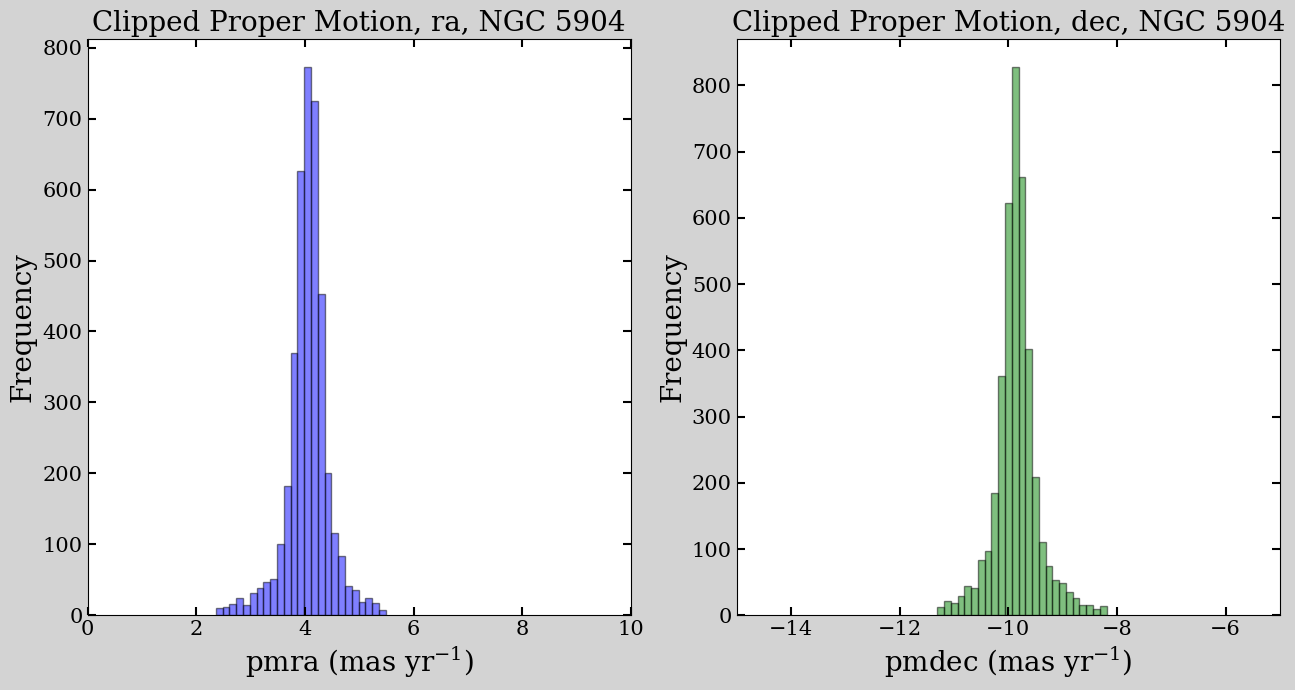

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.hist(ngc_5904_clipped['pmra'], bins=25, color='blue', alpha=0.5, edgecolor='black')

ax1.set_xlim(0, 10)

ax1.set_ylabel(r'Frequency', fontsize=20)
ax1.set_xlabel(r"pmra (mas yr$^{-1}$)", fontsize=20)
ax1.set_title(r'Clipped Proper Motion, ra, NGC 5904', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(2500))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax1.grid(False, which='both')

ax2.hist(ngc_5904_clipped['pmdec'], bins=25, color='green', alpha=0.5, edgecolor='black')

ax2.set_xlim(-15, -5)

ax2.set_ylabel(r'Frequency', fontsize=20)
ax2.set_xlabel(r"pmdec (mas yr$^{-1}$)", fontsize=20)
ax2.set_title(r'Clipped Proper Motion, dec, NGC 5904', fontsize=20)

ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5000))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax2.grid(False, which='both')

plt.tight_layout()

Observamos que estas distribuciones aún presentan algunos outliers. Podemos ser aún mas estrictos con el filtro, y eliminar, para el dataset original, los datos que se encuentren fuera de, por ejemplo, 0.5 sigma.

In [13]:
# Creamos un nuevo dataset para el cúmulo, eliminando valores de pmra y pmdec values que estén sobre o bajo 0.5 sigma.
ngc_5904_clipped = ngc_5904[(ngc_5904['pmra'] > params_ra[1] - 0.5*params_ra[2]) & (ngc_5904['pmra'] < params_ra[1] + 0.5*params_ra[2])]
ngc_5904_clipped = ngc_5904_clipped[(ngc_5904_clipped['pmdec'] > params_dec[1] - 0.5*params_dec[2]) & (ngc_5904_clipped['pmdec'] < params_dec[1] + 0.5*params_dec[2])]

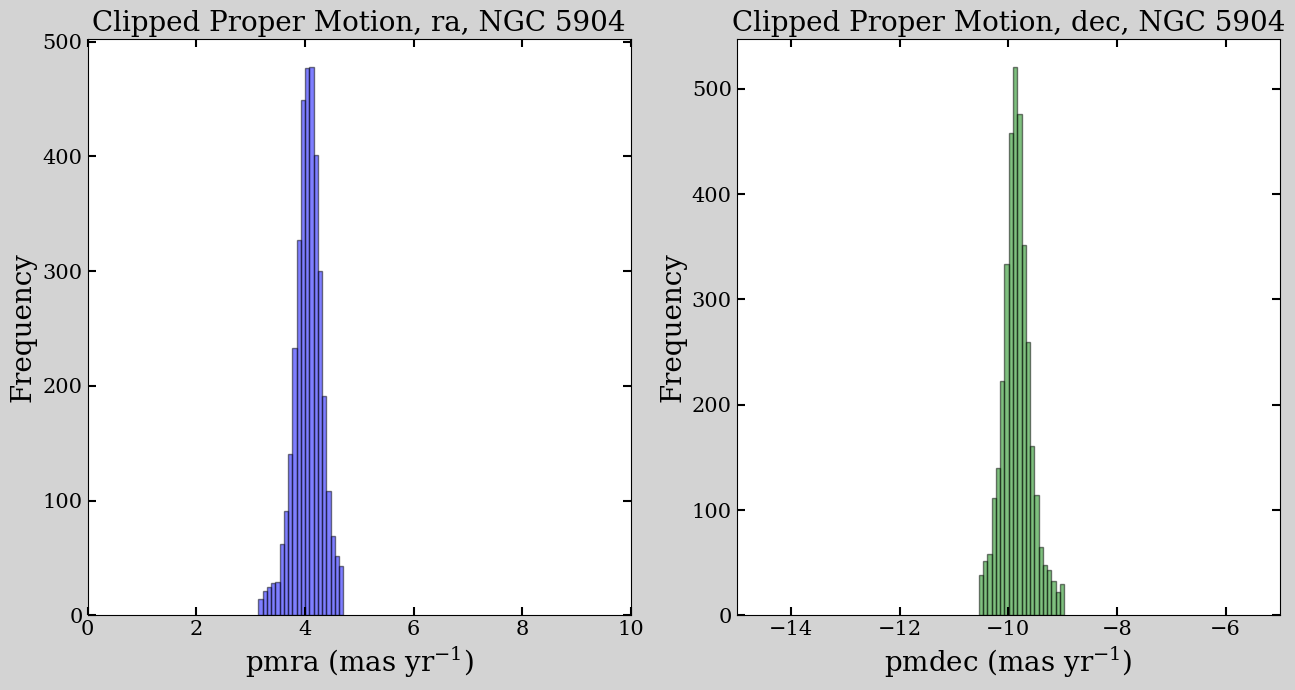

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.hist(ngc_5904_clipped['pmra'], bins=20, color='blue', alpha=0.5, edgecolor='black')

ax1.set_xlim(0, 10)

ax1.set_ylabel(r'Frequency', fontsize=20)
ax1.set_xlabel(r"pmra (mas yr$^{-1}$)", fontsize=20)
ax1.set_title(r'Clipped Proper Motion, ra, NGC 5904', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(2500))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax1.grid(False, which='both')

ax2.hist(ngc_5904_clipped['pmdec'], bins=20, color='green', alpha=0.5, edgecolor='black')

ax2.set_xlim(-15, -5)

ax2.set_ylabel(r'Frequency', fontsize=20)
ax2.set_xlabel(r"pmdec (mas yr$^{-1}$)", fontsize=20)
ax2.set_title(r'Clipped Proper Motion, dec, NGC 5904', fontsize=20)

ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5000))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax2.grid(False, which='both')

plt.tight_layout()

Podemos entonces, realizar un nuevo gráfico de densidad con los datos filtrados.

<Figure size 500x500 with 0 Axes>

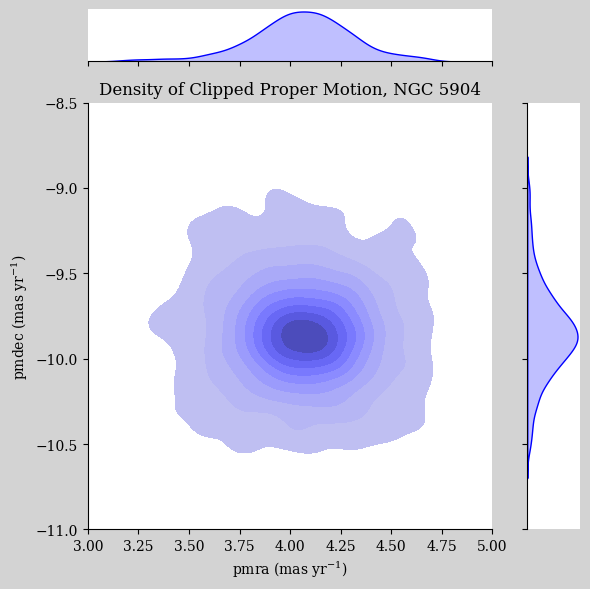

In [15]:
plt.figure(figsize=(5, 5))

sns_plot = sns.jointplot(data=ngc_5904_clipped, x='pmra', y='pmdec', kind='kde', color='blue', fill=True, height=6)

ax_joint = sns_plot.ax_joint
ax_joint.set_xlim(3, 5)
ax_joint.set_ylim(-11, -8.5)

ax_joint.set_xlabel(r'pmra (mas yr$^{-1}$)')
ax_joint.set_ylabel(r'pmdec (mas yr$^{-1}$)')

ax_joint.set_title('Density of Clipped Proper Motion, NGC 5904')

plt.tight_layout()

Podemos también, hacer un scatter plot de ra y dec, para observar cómo se ven los datos de las estrellas del cúmulo NGC 5904.

Text(0.5, 1.0, 'NGC 5904, Filtered')

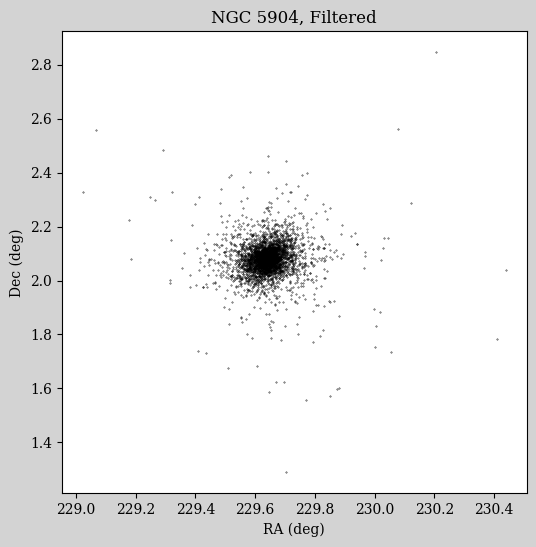

In [79]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(ngc_5904_clipped['ra'], ngc_5904_clipped['dec'], s=0.1, color='black')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('NGC 5904, Filtered')

### $\text{c)}$

Una vez filtradas las estrellas del cúmulo, haremos un diagrama color-magnitud, utilizando la magnitud g y el color bp - rp. Para ello, haremos un scatter plot de las columnas 'phot_g_mean_mag' y 'bp_rp' de nuestro dataset.

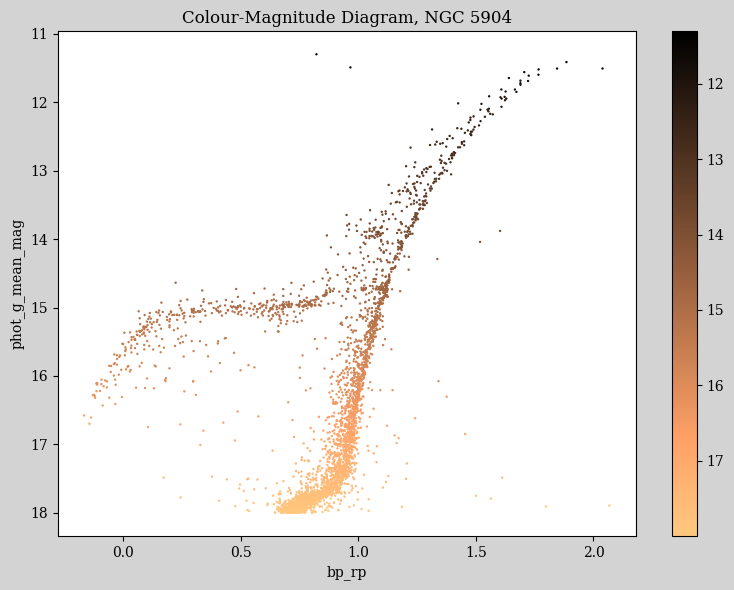

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(ngc_5904_clipped['bp_rp'], ngc_5904_clipped['phot_g_mean_mag'], s=0.5, c=ngc_5904_clipped['phot_g_mean_mag'], cmap='copper')
ax.set_xlabel('bp_rp')
ax.set_ylabel('phot_g_mean_mag')
ax.set_title('Colour-Magnitude Diagram, NGC 5904')
ax.invert_yaxis()

cbar = fig.colorbar(sc)
cbar.ax.invert_yaxis()

plt.tight_layout()

Notamos claramente la secuencia principal, que es la región donde se encuentran la mayoría de las estrellas del cúmulo. Además, la rama horizontal es claramente visible, y podemos observar una cantidad de estrellas no menor en esta región, lo que nos indica que el cúmulo tiene una edad avanzada, lo cual es consistente ya que este cúmulo es un cúmulo globular.

Para el siguiente análisis, filtraremos todos los datos que se encuentren en la región de la rama horizontal. Haremos esto filtrando una zona poligonal del gráfico.

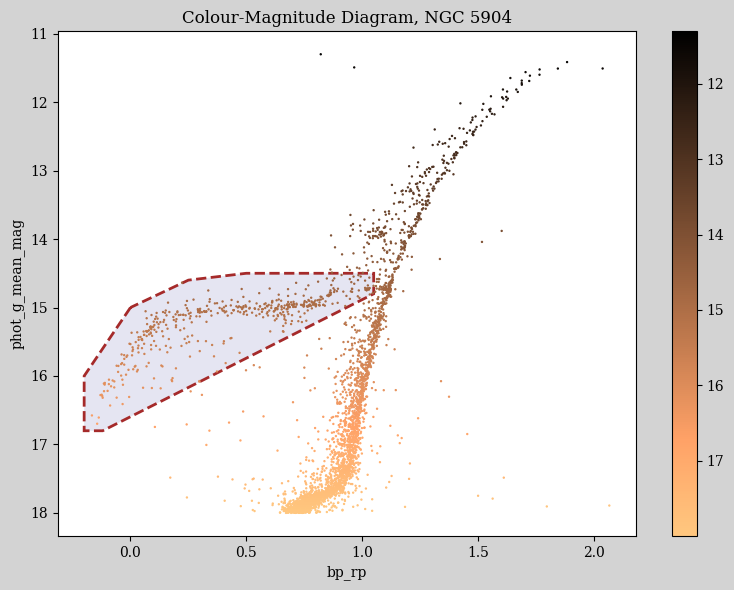

In [81]:
fig, ax = plt.subplots(figsize=(8, 6))

ngc_5904_polygon = plt.Polygon([(0.0, 15), (-0.2, 16), (-0.2, 16.8), (-0.12, 16.8), (1.05, 14.8), (1.05, 14.5), (0.5, 14.5), (0.25, 14.6)],
                               edgecolor='none', facecolor='navy', lw=2, alpha=0.1, ls='--')
ngc_5904_polygon_2 = plt.Polygon([(0.0, 15), (-0.2, 16), (-0.2, 16.8), (-0.12, 16.8), (1.05, 14.8), (1.05, 14.5), (0.5, 14.5), (0.25, 14.6)],
                               edgecolor='brown', facecolor='none', lw=2, ls='--')


ax.add_patch(ngc_5904_polygon)
ax.add_patch(ngc_5904_polygon_2)

sc = ax.scatter(ngc_5904_clipped['bp_rp'], ngc_5904_clipped['phot_g_mean_mag'], s=0.5, c=ngc_5904_clipped['phot_g_mean_mag'], cmap='copper')
ax.set_xlabel('bp_rp')
ax.set_ylabel('phot_g_mean_mag')
ax.set_title('Colour-Magnitude Diagram, NGC 5904')
ax.invert_yaxis()

cbar = fig.colorbar(sc)
cbar.ax.invert_yaxis()

plt.tight_layout()

Ya habiendo identificado la rama horizontal con un polígono, crearemos un nuevo dataset con los datos que se encuentren dentro de esta región.

In [19]:
polygon_coords = [(0.0, 15), (-0.2, 16), (-0.2, 16.8), (-0.12, 16.8), (1.05, 14.8), (1.05, 14.5), (0.5, 14.5), (0.25, 14.6)]
path = mpath.Path(polygon_coords)

inside_polygon = path.contains_points(ngc_5904_clipped[['bp_rp', 'phot_g_mean_mag']].values)
ngc_5904_clipped_hb = ngc_5904_clipped[inside_polygon].copy()


Haremos un nuevo diagrama color-magnitud con los datos filtrados, y observaremos cómo se ven los datos filtrados.

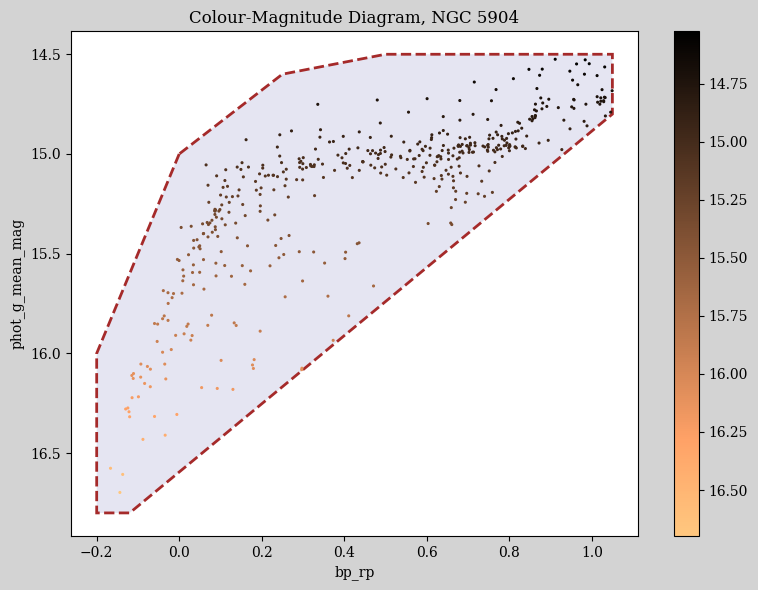

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))

ngc_5904_polygon = plt.Polygon([(0.0, 15), (-0.2, 16), (-0.2, 16.8), (-0.12, 16.8), (1.05, 14.8), (1.05, 14.5), (0.5, 14.5), (0.25, 14.6)],
                               edgecolor='none', facecolor='navy', lw=2, alpha=0.1, ls='--')
ngc_5904_polygon_2 = plt.Polygon([(0.0, 15), (-0.2, 16), (-0.2, 16.8), (-0.12, 16.8), (1.05, 14.8), (1.05, 14.5), (0.5, 14.5), (0.25, 14.6)],
                               edgecolor='brown', facecolor='none', lw=2, ls='--')


ax.add_patch(ngc_5904_polygon)
ax.add_patch(ngc_5904_polygon_2)

sc = ax.scatter(ngc_5904_clipped_hb['bp_rp'], ngc_5904_clipped_hb['phot_g_mean_mag'], s=1.5, c=ngc_5904_clipped_hb['phot_g_mean_mag'], cmap='copper')
ax.set_xlabel('bp_rp')
ax.set_ylabel('phot_g_mean_mag')
ax.set_title('Colour-Magnitude Diagram, NGC 5904')
ax.invert_yaxis()

cbar = fig.colorbar(sc)
cbar.ax.invert_yaxis()

plt.tight_layout()


Para obtener la magnitud aparente promedio de la rama horizontal, podemos calcular estadísticas descriptivas de la columna 'phot_g_mean_mag' de nuestro dataset filtrado, utilizando la función ```describe()``` de ```pandas```.

In [59]:
descriptive_stats_g_mag = ngc_5904_clipped_hb['phot_g_mean_mag'].describe()

# display mean plus minus 1 sigma in latex format
mean = descriptive_stats_g_mag['mean']
std = descriptive_stats_g_mag['std']

print('Magnitud aparente promedio de la secuencia principal: {:.3} ± {:.1} mag'.format(mean, std))


Magnitud aparente promedio de la secuencia principal: 15.2 ± 0.4 mag


Para calcular las magnitudes absolutas de las estrellas, utilizaremos la fórmula:

$$m - M = 5 \cdot \log_{10}\left(\frac{d}{10\hspace{1mm}\text{pc}}\right) \hspace{3mm}\rightarrow \hspace{3mm}M = -5 \cdot \log_{10}\left(\frac{d}{10\hspace{1mm}\text{pc}}\right) + m$$


Donde $m$ es la magnitud aparente, $M$ es la magnitud absoluta, y $d$ es la distancia en parsecs. Para los cálculos, consideraremos que la distancia al cúmulo es de $7.4$ kpc, es decir, $7400$ parsecs.

In [67]:
def abs_mag(app_mag):
    return -5 * np.log10(7400 / 10) + app_mag

ngc_5904_clipped_hb['abs_g_mag'] = abs_mag(ngc_5904_clipped_hb['phot_g_mean_mag'])
ngc_5904_clipped_hb['abs_g_mag'].describe()

count    457.000000
mean       0.844929
std        0.411319
min        0.178834
25%        0.606561
50%        0.710105
75%        1.009164
max        2.351196
Name: abs_g_mag, dtype: float64

Determinamos entonces que la magnitud absoluta promedio de las estrellas de la rama horizontal es de $0.8 \pm 0.4$ mag. Notamos que la desviación estándar es equivalente a la de la magnitud aparente, lo cual es consistente ya que si bien los valores son distintos, la distribución de los datos es la misma.

### $\text{d)}$

Realizaremos el mismo análisis de los puntos anteriores, pero para el cúmulo globular NGC 2808. Primero obtendremos sus coordenadas de ra y dec en grados, y luego haremos un query en la base de datos de GAIA para obtener los datos de las estrellas que se encuentran en un radio de 1 grado centrado en el cúmulo.

In [121]:
ngc_2808_coordinates = SkyCoord.from_name('NGC 2808')
ngc_2808_coordinates

<SkyCoord (ICRS): (ra, dec) in deg
    (138.01291667, -64.8635)>

```sql
SELECT *
FROM gaiadr3.gaia_source
WHERE 1 = CONTAINS(POINT(138.01291667, -64.8635), CIRCLE(ra, dec, 1))
AND phot_g_mean_mag < 18
```

In [125]:
ngc_2808_path = 'ngc2808-query3.csv'
ngc_2808 = pd.read_csv(ngc_2808_path)
print(ngc_2808.columns)
ngc_2808.head()

Index(['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       ...
       'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper',
       'ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper',
       'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
       'libname_gspphot'],
      dtype='object', length=152)


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 5248691348461451136,5248691348461451136,604268943,2016.0,139.090173,0.022713,-65.200662,0.023000,0.133743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1636148068921376768,Gaia DR3 5248276557694301184,5248276557694301184,707756773,2016.0,137.763812,0.032036,-65.728324,0.029541,0.347871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1636148068921376768,Gaia DR3 5248100219216006400,5248100219216006400,1370512826,2016.0,138.967899,0.051572,-65.777524,0.052436,0.579308,...,0.0296,0.0072,0.0603,0.0231,0.0056,0.0473,0.0122,0.0030,0.0250,PHOENIX
3,1636148068921376768,Gaia DR3 5248100223516602624,5248100223516602624,512321755,2016.0,138.976734,0.020043,-65.773759,0.020842,0.342772,...,0.5469,0.5181,0.5666,0.4372,0.4138,0.4532,0.2340,0.2216,0.2426,MARCS
4,1636148068921376768,Gaia DR3 5248100223516602752,5248100223516602752,1750566714,2016.0,138.979383,0.039437,-65.775546,0.040686,0.416703,...,0.0395,0.0174,0.0642,0.0324,0.0143,0.0528,0.0175,0.0077,0.0285,MARCS


In [126]:
ngc_2808 = ngc_2808.dropna(subset=['pmra', 'pmdec'])

Realizamos un scatter plot de ra vs dec para observar la distribución de las estrellas en el cúmulo.

Text(0.5, 1.0, 'NGC 2808')

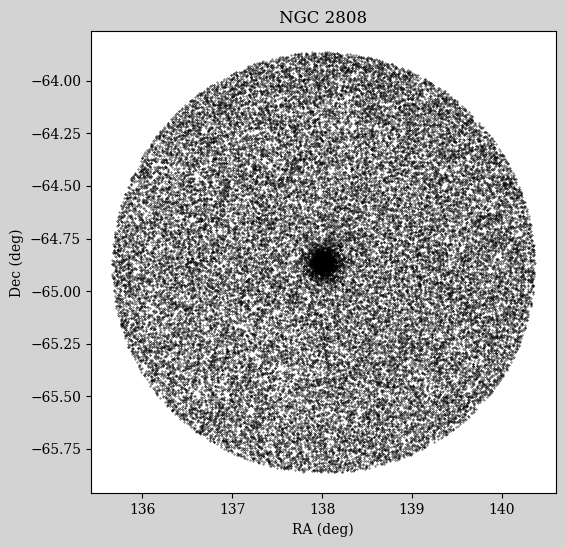

In [127]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(ngc_2808['ra'], ngc_2808['dec'], s=0.1, color='black')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('NGC 2808')

Ahora realizaremos un plot de densidad del movimiento propio de las estrellas en el cúmulo. Utilizaremos ```jointplot``` de ```seaborne``` para ello.

ValueError: Contour levels must be increasing

<Figure size 500x500 with 0 Axes>

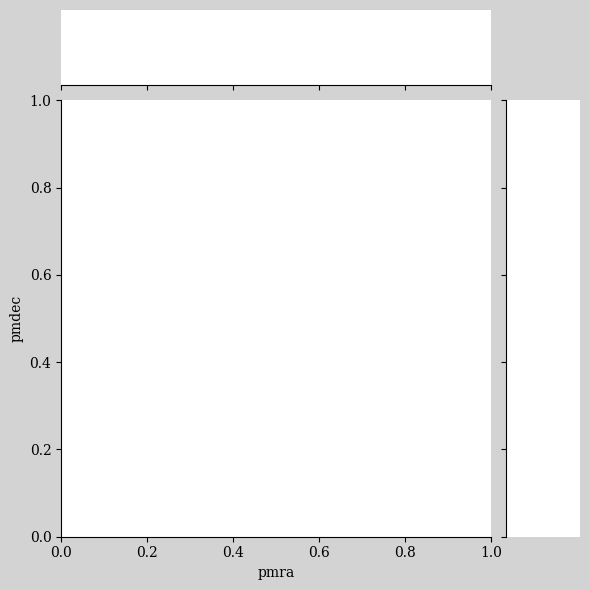

In [43]:
plt.figure(figsize=(5, 5))

ngc_2808['pmra'] = ngc_2808['pmra'].dropna()
ngc_2808['pmdec'] = ngc_2808['pmdec'].dropna()

sns_plot = sns.jointplot(data=ngc_2808, x='pmra', y='pmdec', kind='kde', color='blue', fill=True, height=6, dropna=True)

ax_joint = sns_plot.ax_joint
ax_joint.set_xlim(-20, 10)
ax_joint.set_ylim(-10, 20)

ax_joint.set_xlabel(r'pmra (mas yr$^{-1}$)')
ax_joint.set_ylabel(r'pmdec (mas yr$^{-1}$)')

ax_joint.set_title('Density of Proper Motion, NGC 2808')

plt.tight_layout()

Es necesario eliminar outliers de los datos, debido a que la función ```jointplot``` falla al tratar de ordenar datos que tienen mucha varianza.

In [50]:
ngc_2808['pmra'].describe()

count    45462.000000
mean        -4.824285
std          5.896690
min       -255.744340
25%         -6.848035
50%         -4.538734
75%         -2.446817
max        235.009158
Name: pmra, dtype: float64

In [51]:
ngc_2808['pmdec'].describe()

count    45462.000000
mean         4.739347
std          5.833495
min       -288.587234
25%          2.380141
50%          4.463224
75%          6.635173
max        411.251765
Name: pmdec, dtype: float64

Vemos que, para ambas columnas, en general los valores se encuentran en un rango de $-10$ a $10$. Tomando en cuenta los valores mínimos y máximos de las distribuciones, podemos filtrar los datos que se encuentren fuera de un rango de $-200$ a $200$. Así, nos aseguramos de eliminar outliers que puedan afectar el análisis, sin afectar a los datos que realmente nos interesan.

In [128]:
# Eliminamos outliers 
ngc_2808 = ngc_2808[(ngc_2808['pmra'] > -200) & (ngc_2808['pmra'] < 200)]
ngc_2808 = ngc_2808[(ngc_2808['pmdec'] > -200) & (ngc_2808['pmdec'] < 200)]

<Figure size 500x500 with 0 Axes>

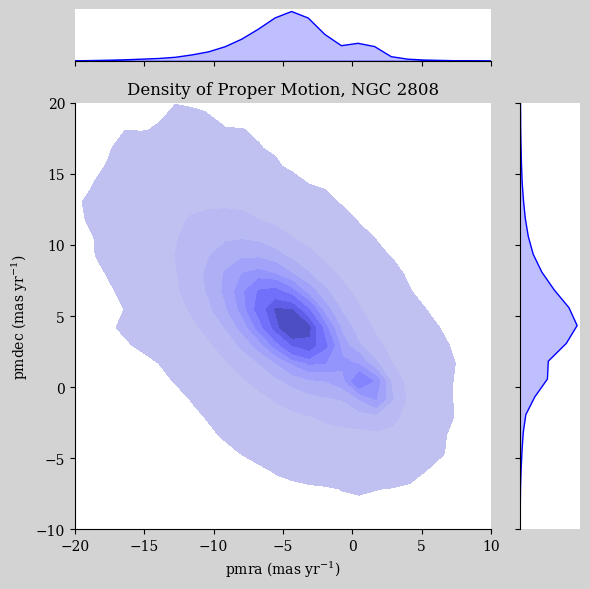

In [129]:
plt.figure(figsize=(5, 5))

ngc_2808['pmra'] = ngc_2808['pmra'].dropna()
ngc_2808['pmdec'] = ngc_2808['pmdec'].dropna()

sns_plot = sns.jointplot(data=ngc_2808, x='pmra', y='pmdec', kind='kde', color='blue', fill=True, height=6, dropna=True)

ax_joint = sns_plot.ax_joint
ax_joint.set_xlim(-20, 10)
ax_joint.set_ylim(-10, 20)

ax_joint.set_xlabel(r'pmra (mas yr$^{-1}$)')
ax_joint.set_ylabel(r'pmdec (mas yr$^{-1}$)')

ax_joint.set_title('Density of Proper Motion, NGC 2808')

plt.tight_layout()

Notamos que existen dos puntos de densidad más alta, y debemos distinguir cual de estos corresponde al cúmulo. Haremos histogramas para observar la distribución de movimientos propios en ra y dec.

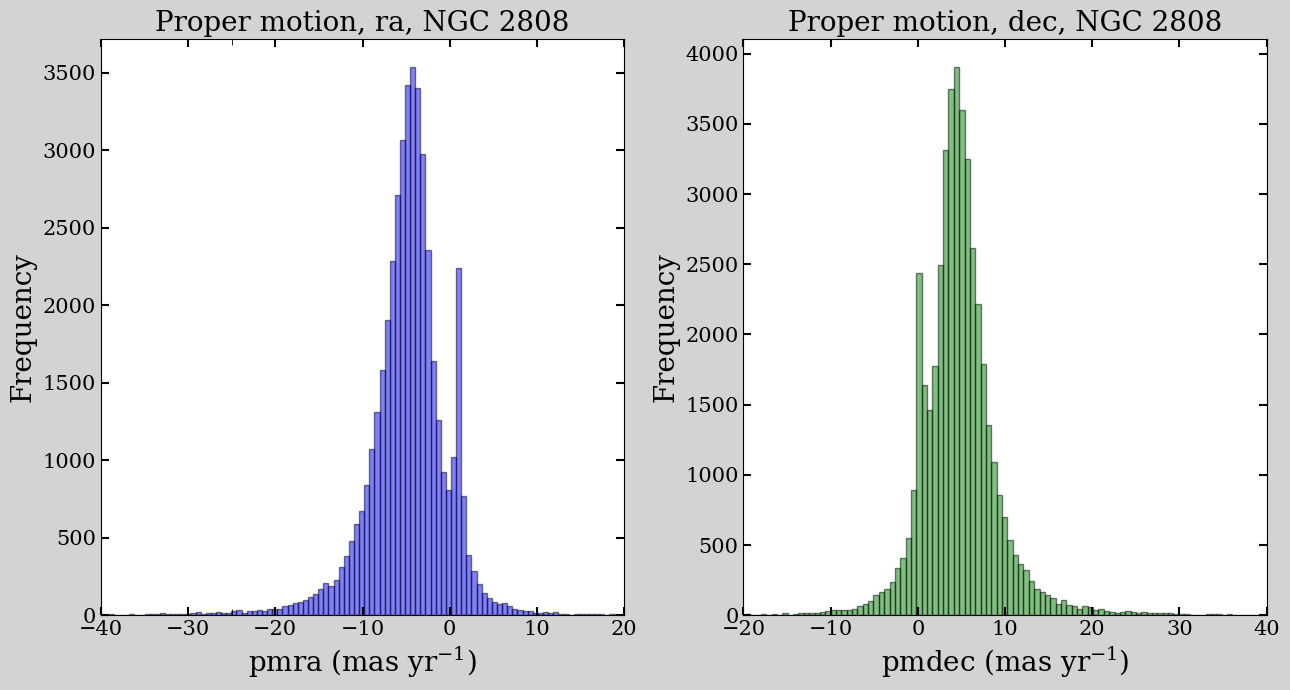

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.hist(ngc_2808['pmra'], bins=400, color='blue', alpha=0.5, edgecolor='black')

ax1.set_xlim(-40, 20)

ax1.set_ylabel(r'Frequency', fontsize=20)
ax1.set_xlabel(r"pmra (mas yr$^{-1}$)", fontsize=20)
ax1.set_title(r'Proper motion, ra, NGC 2808', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(2500))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax1.grid(False, which='both')

ax2.hist(ngc_2808['pmdec'], bins=400, color='green', alpha=0.5, edgecolor='black')

ax2.set_xlim(-20, 40)

ax2.set_ylabel(r'Frequency', fontsize=20)
ax2.set_xlabel(r"pmdec (mas yr$^{-1}$)", fontsize=20)
ax2.set_title(r'Proper motion, dec, NGC 2808', fontsize=20)

ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5000))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax2.grid(False, which='both')

plt.tight_layout()

Observamos que las distribuciones son más uniformes que para el cúmulo NGC 5904, con una pequeña región de mayor densidad de movimiento propio, lo cual, análogamente al cúmulo anterior, podemos interpretar como las estrellas que comparten el movimiento propio en NGC 2808. Dado que en este caso la distribución de movimientos propios que no pertenecen al cúmulo es mucho más significativa que para el cúmulo anterior, podemos tomar otra ruta para filtrar los datos. Podemos realizar un ajuste gaussiano a la distribución mayor, y encontrar a qué desviación estándar se encuentran los datos del cúmulo, y filtrar ese rango de datos.

In [131]:
pmra_data = ngc_2808['pmra'].dropna()

# Calculamos el histograma eligiendo 800 bins
bin_count_ra = 400
hist_ra, bin_edges_ra = np.histogram(pmra_data, bins=bin_count_ra, density=False)
bin_centers_ra = (bin_edges_ra[:-1] + bin_edges_ra[1:]) / 2

# Utilizar un kernel Gaussiano para convolucionar el histograma y suavizarlo
gaussian_kernel_ra = Gaussian1DKernel(stddev=0.5)  # Elegimos sigma 0.5, arbitrario pero conveniente
smoothed_hist_ra = convolve(hist_ra, gaussian_kernel_ra)

# Ajustamos una Gaussiana al histograma suavizado
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Calculamos el promedio ponderado y la desviación estándar para el histograma
weighted_mean_ra = np.sum(bin_centers_ra * hist_ra) / np.sum(hist_ra)
print(max(hist_ra))
weighted_std = np.sqrt(np.sum(hist_ra * (bin_centers_ra - weighted_mean_ra) ** 2) / np.sum(hist_ra))

# Usamos estos valores como priors
initial_guess_ra = [max(hist_ra), weighted_mean_ra, weighted_std]

# Hacemos el ajuste utilizando curve_fit
params_ra, _ = curve_fit(gaussian, bin_centers_ra, smoothed_hist_ra, p0=initial_guess_ra)

# ---------------------------

# Repetimos el mismo proceso para pmdec

pmdec_data = ngc_2808['pmdec'].dropna()

bin_count_dec = 400
hist_dec, bin_edges_dec = np.histogram(pmdec_data, bins=bin_count_dec, density=False)
bin_centers_dec = (bin_edges_dec[:-1] + bin_edges_dec[1:]) / 2

gaussian_kernel_dec = Gaussian1DKernel(stddev=0.5) 
smoothed_hist_dec = convolve(hist_dec, gaussian_kernel_dec)

weighted_mean_dec = np.sum(bin_centers_dec * hist_dec) / np.sum(hist_dec)
weighted_std = np.sqrt(np.sum(hist_dec * (bin_centers_dec - weighted_mean_dec)**2) / np.sum(hist_dec))

initial_guess_dec = [max(hist_dec), weighted_mean_dec, weighted_std]

params_dec, _ = curve_fit(gaussian, bin_centers_dec, smoothed_hist_dec, p0=initial_guess_dec)

3539


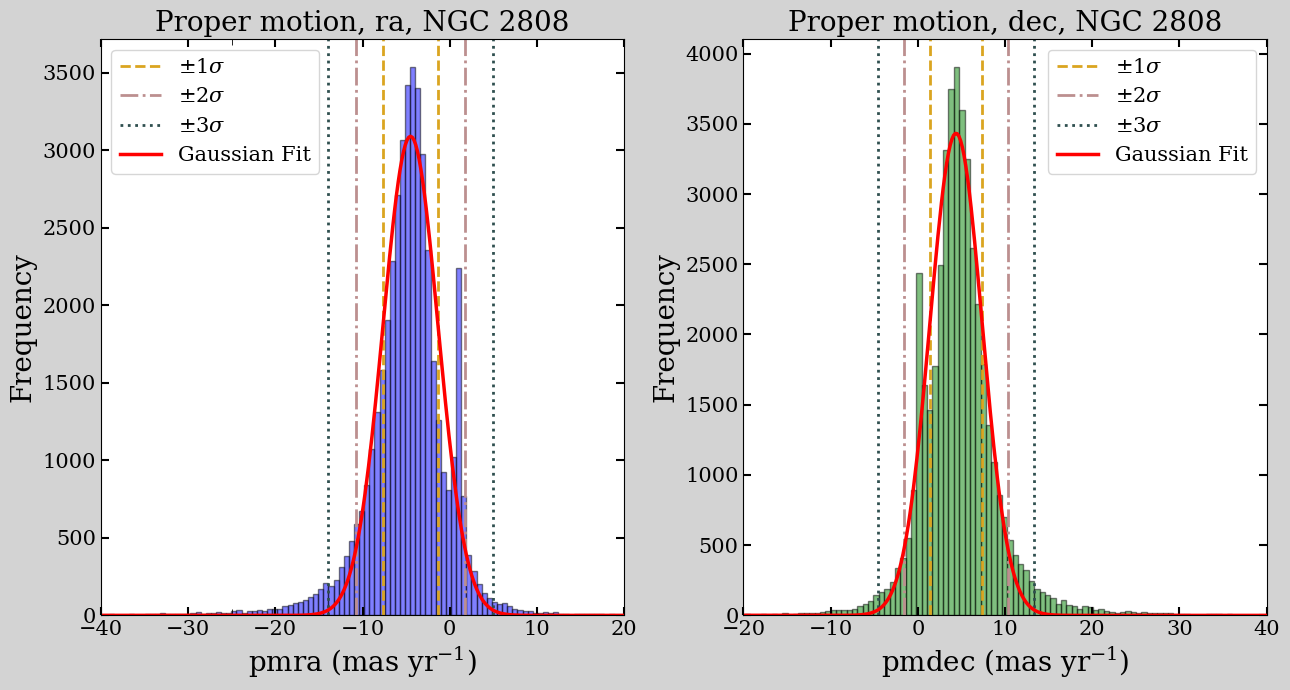

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.hist(ngc_2808['pmra'], bins=400, color='blue', alpha=0.5, edgecolor='black')

# Añadimos líneas verticales para 1, 2 y 3 sigma
sigma = params_ra[2]
ax1.axvline(params_ra[1] + sigma, color='goldenrod', linestyle='--', label=r'$\pm 1 \sigma$', linewidth=2)
ax1.axvline(params_ra[1] - sigma, color='goldenrod', linestyle='--', linewidth=2)
ax1.axvline(params_ra[1] + 2*sigma, color='rosybrown', linestyle='-.', label=r'$\pm 2 \sigma$', linewidth=2)
ax1.axvline(params_ra[1] - 2*sigma, color='rosybrown', linestyle='-.', linewidth=2)
ax1.axvline(params_ra[1] + 3*sigma, color='darkslategray', linestyle=':', label=r'$\pm 3 \sigma$', linewidth=2)
ax1.axvline(params_ra[1] - 3*sigma, color='darkslategray', linestyle=':', linewidth=2)

ax1.plot(np.linspace(-100, 100, 1000), gaussian(np.linspace(-100, 100, 1000), *params_ra), color='red', label='Gaussian Fit', linewidth=2.5)

ax1.set_xlim(-40, 20)

ax1.set_ylabel(r'Frequency', fontsize=20)
ax1.set_xlabel(r"pmra (mas yr$^{-1}$)", fontsize=20)
ax1.set_title(r'Proper motion, ra, NGC 2808', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(2500))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax1.grid(False, which='both')
ax1.legend(fontsize=15, markerscale=1)

ax2.hist(ngc_2808['pmdec'], bins=400, color='green', alpha=0.5, edgecolor='black')

sigma = params_dec[2]
ax2.axvline(params_dec[1] + sigma, color='goldenrod', linestyle='--', label=r'$\pm 1 \sigma$', linewidth=2)
ax2.axvline(params_dec[1] - sigma, color='goldenrod', linestyle='--', linewidth=2)
ax2.axvline(params_dec[1] + 2*sigma, color='rosybrown', linestyle='-.', label=r'$\pm 2 \sigma$', linewidth=2)
ax2.axvline(params_dec[1] - 2*sigma, color='rosybrown', linestyle='-.', linewidth=2)
ax2.axvline(params_dec[1] + 3*sigma, color='darkslategray', linestyle=':', label=r'$\pm 3 \sigma$', linewidth=2)
ax2.axvline(params_dec[1] - 3*sigma, color='darkslategray', linestyle=':', linewidth=2)

ax2.plot(np.linspace(-100, 100, 1000), gaussian(np.linspace(-100, 100, 1000), *params_dec), color='red', label='Gaussian Fit', linewidth=2.5)

ax2.set_xlim(-20, 40)

ax2.set_ylabel(r'Frequency', fontsize=20)
ax2.set_xlabel(r"pmdec (mas yr$^{-1}$)", fontsize=20)
ax2.set_title(r'Proper motion, dec, NGC 2808', fontsize=20)

ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5000))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax2.grid(False, which='both')
ax2.legend(fontsize=15, markerscale=1)

# space between plots
plt.tight_layout()

Notamos que para pmra, los datos del cúmulo se encuentran en un rango de $+1\sigma$ a $+2\sigma$, y para pmdec, en un rango de $-1\sigma$ a $-2\sigma$. Podemos entonces filtrar los datos que se encuentren fuera de estos rangos.

In [133]:
# Para pmra, eliminamos valores que estén bajo +1 sigma y sobre +2 sigma
ngc_2808_clipped = ngc_2808[(ngc_2808['pmra'] > params_ra[1] + 1*params_ra[2]) & (ngc_2808['pmra'] < params_ra[1] + 2*params_ra[2])]

# Para pmdec, eliminamos valores que estén bajo -2 sigma y sobre -1 sigma
ngc_2808_clipped = ngc_2808_clipped[(ngc_2808_clipped['pmdec'] > params_dec[1] - 2*params_dec[2]) & (ngc_2808_clipped['pmdec'] < params_dec[1] - 1*params_dec[2])]


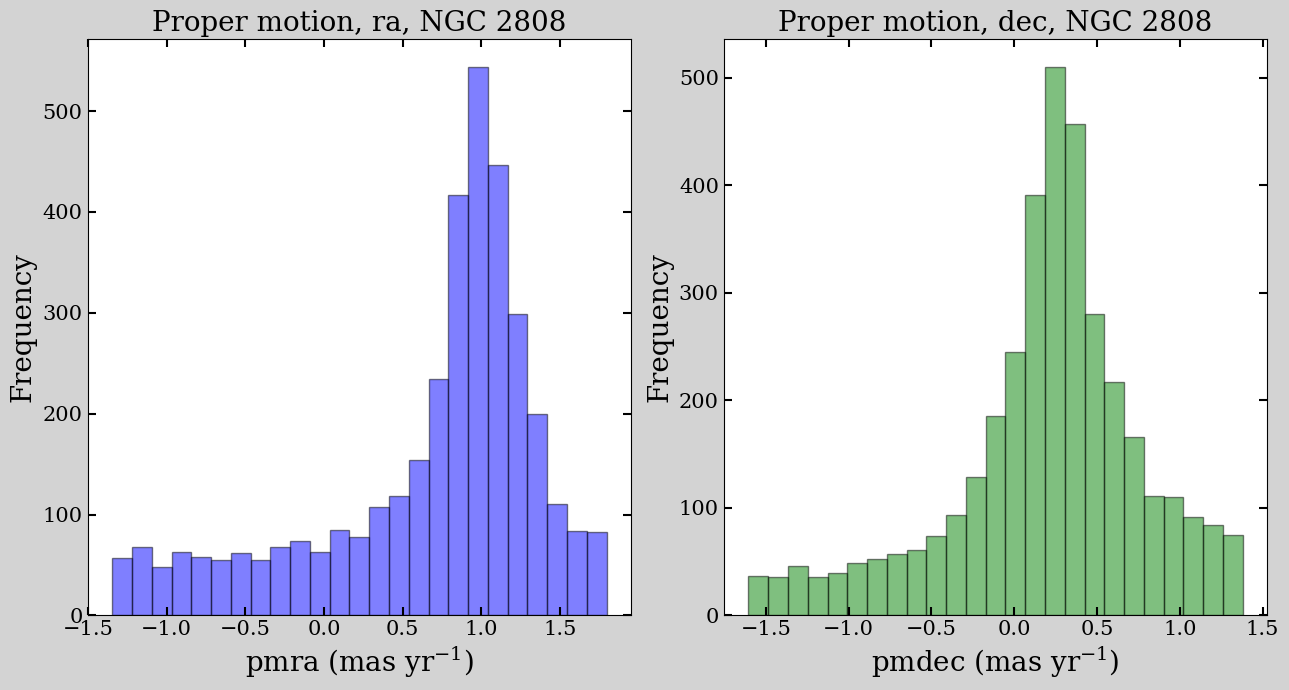

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.hist(ngc_2808_clipped['pmra'], bins=25, color='blue', alpha=0.5, edgecolor='black')

# ax1.set_xlim(-10, 0)

ax1.set_ylabel(r'Frequency', fontsize=20)
ax1.set_xlabel(r"pmra (mas yr$^{-1}$)", fontsize=20)
ax1.set_title(r'Proper motion, ra, NGC 2808', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(2500))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax1.grid(False, which='both')

ax2.hist(ngc_2808_clipped['pmdec'], bins=25, color='green', alpha=0.5, edgecolor='black')

# ax2.set_xlim(0, 10)

ax2.set_ylabel(r'Frequency', fontsize=20)
ax2.set_xlabel(r"pmdec (mas yr$^{-1}$)", fontsize=20)
ax2.set_title(r'Proper motion, dec, NGC 2808', fontsize=20)

ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5000))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax2.grid(False, which='both')

plt.tight_layout()

Podemos incluso hacer una selección más estricta, y filtrar nuevamente los datos para eliminar las "colas" de las distribuciones, y así aislar mejor los datos del cúmulo.

In [135]:
# Para pmra, eliminamos valores que estén bajo +1.6 sigma y sobre +1.9 sigma
ngc_2808_clipped = ngc_2808[(ngc_2808['pmra'] > params_ra[1] + 1.6*params_ra[2]) & (ngc_2808['pmra'] < params_ra[1] + 1.9*params_ra[2])]

# Para pmdec, eliminamos valores que estén bajo -1.6 sigma y sobre -1.2 sigma
ngc_2808_clipped = ngc_2808_clipped[(ngc_2808_clipped['pmdec'] > params_dec[1] - 1.6*params_dec[2]) & (ngc_2808_clipped['pmdec'] < params_dec[1] - 1.2*params_dec[2])]


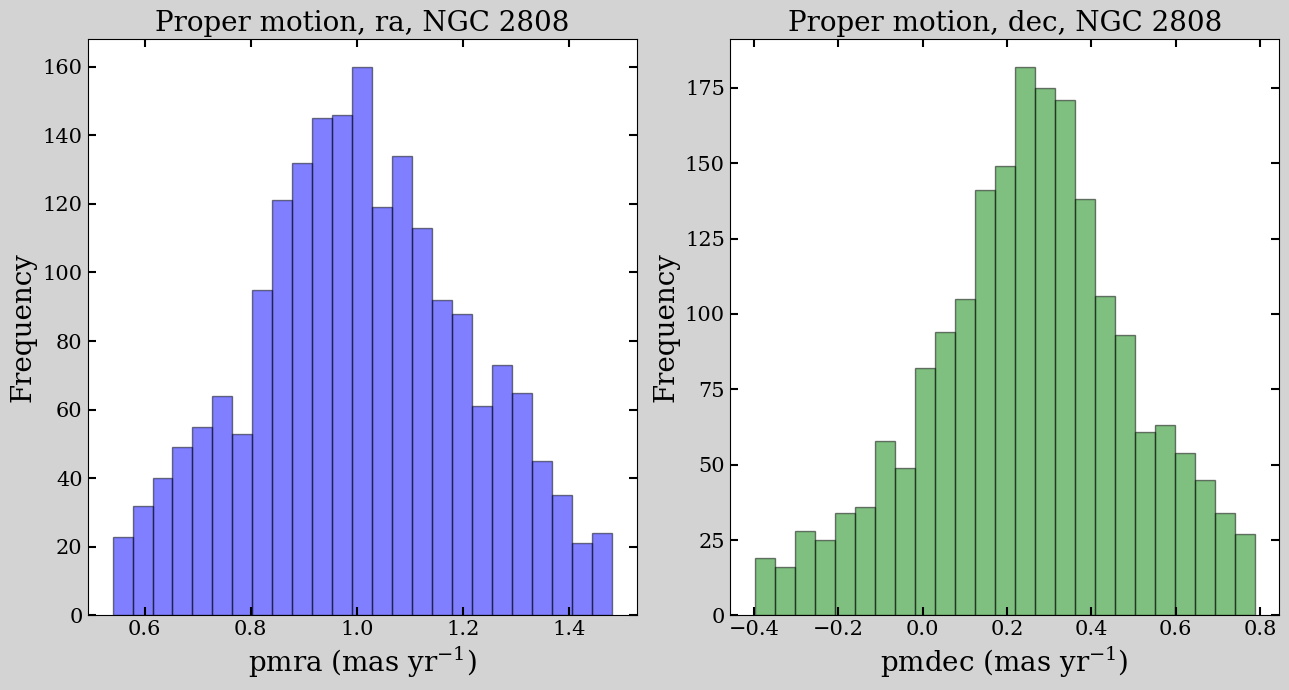

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.hist(ngc_2808_clipped['pmra'], bins=25, color='blue', alpha=0.5, edgecolor='black')

# ax1.set_xlim(-10, 0)

ax1.set_ylabel(r'Frequency', fontsize=20)
ax1.set_xlabel(r"pmra (mas yr$^{-1}$)", fontsize=20)
ax1.set_title(r'Proper motion, ra, NGC 2808', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(2500))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax1.grid(False, which='both')

ax2.hist(ngc_2808_clipped['pmdec'], bins=25, color='green', alpha=0.5, edgecolor='black')

# ax2.set_xlim(0, 10)

ax2.set_ylabel(r'Frequency', fontsize=20)
ax2.set_xlabel(r"pmdec (mas yr$^{-1}$)", fontsize=20)
ax2.set_title(r'Proper motion, dec, NGC 2808', fontsize=20)

ax2.xaxis.set_minor_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5000))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax2.grid(False, which='both')

plt.tight_layout()

<Figure size 500x500 with 0 Axes>

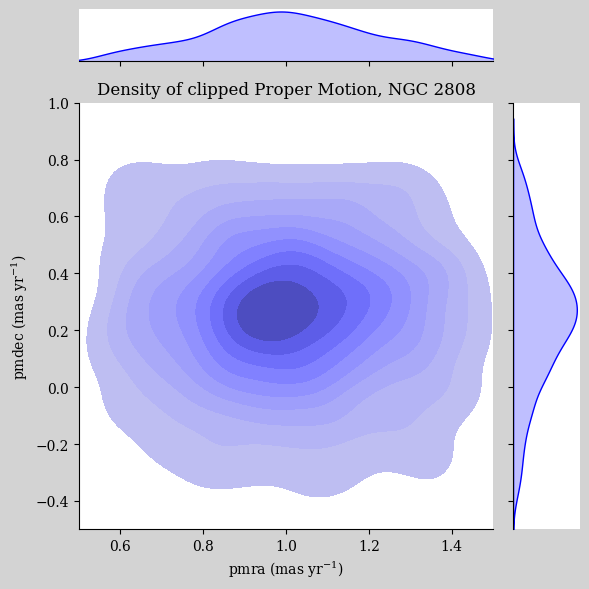

In [137]:
plt.figure(figsize=(5, 5))

ngc_2808['pmra'] = ngc_2808['pmra'].dropna()
ngc_2808['pmdec'] = ngc_2808['pmdec'].dropna()

sns_plot = sns.jointplot(data=ngc_2808_clipped, x='pmra', y='pmdec', kind='kde', color='blue', fill=True, height=6, dropna=True)

ax_joint = sns_plot.ax_joint
ax_joint.set_xlim(0.5, 1.5)
ax_joint.set_ylim(-0.5, 1)

ax_joint.set_xlabel(r'pmra (mas yr$^{-1}$)')
ax_joint.set_ylabel(r'pmdec (mas yr$^{-1}$)')

ax_joint.set_title('Density of clipped Proper Motion, NGC 2808')

plt.tight_layout()

Text(0.5, 1.0, 'NGC 2808, Filtered')

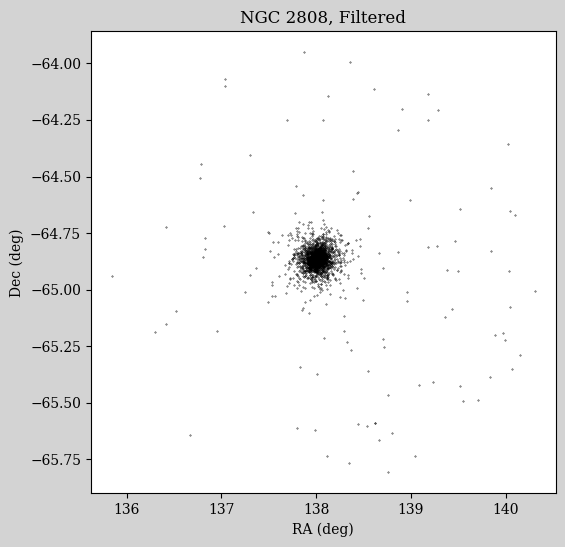

In [138]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(ngc_2808_clipped['ra'], ngc_2808_clipped['dec'], s=0.1, color='black')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('NGC 2808, Filtered')

Una vez filtradas las estrellas del cúmulo, procedemos a realizar el diagrama color-magnitud.

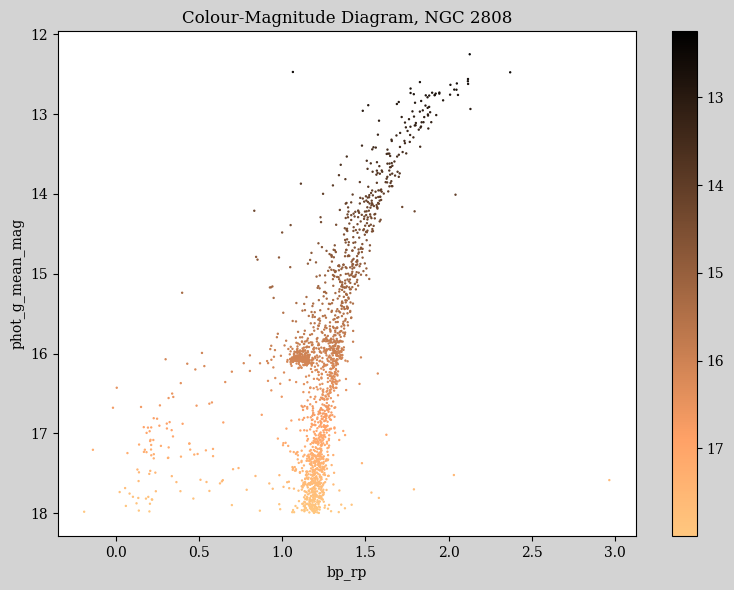

In [139]:
fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(ngc_2808_clipped['bp_rp'], ngc_2808_clipped['phot_g_mean_mag'], s=0.5, c=ngc_2808_clipped['phot_g_mean_mag'], cmap='copper')
ax.set_xlabel('bp_rp')
ax.set_ylabel('phot_g_mean_mag')
ax.set_title('Colour-Magnitude Diagram, NGC 2808')
ax.invert_yaxis()

cbar = fig.colorbar(sc)
cbar.ax.invert_yaxis()

plt.tight_layout()

Nuevamente, definiremos una zona poligonal para filtrar las estrellas que pertenecen a la rama horizontal.

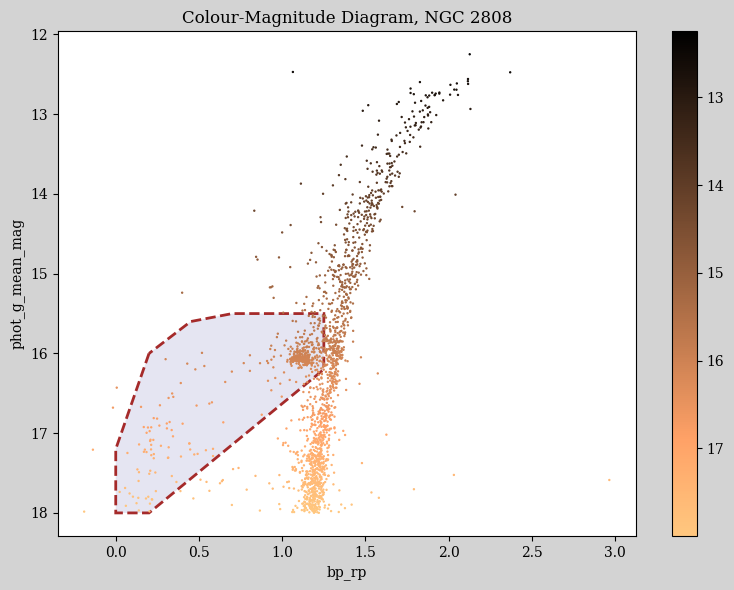

In [141]:
fig, ax = plt.subplots(figsize=(8, 6))

ngc_2808_polygon = plt.Polygon([(0.2, 16), (-0.0, 17.2), (-0.0, 18), (0.2, 18), (1.25, 16.2), (1.25, 15.5), (0.7, 15.5), (0.45, 15.6)],
                               edgecolor='none', facecolor='navy', lw=2, alpha=0.1, ls='--')

ngc_2808_polygon_2 = plt.Polygon([(0.2, 16), (-0.0, 17.2), (-0.0, 18), (0.2, 18), (1.25, 16.2), (1.25, 15.5), (0.7, 15.5), (0.45, 15.6)],
                                 edgecolor='brown', facecolor='none', lw=2, ls='--')

ax.add_patch(ngc_2808_polygon)
ax.add_patch(ngc_2808_polygon_2)

sc = ax.scatter(ngc_2808_clipped['bp_rp'], ngc_2808_clipped['phot_g_mean_mag'], s=0.5, c=ngc_2808_clipped['phot_g_mean_mag'], cmap='copper')
ax.set_xlabel('bp_rp')
ax.set_ylabel('phot_g_mean_mag')
ax.set_title('Colour-Magnitude Diagram, NGC 2808')
ax.invert_yaxis()

cbar = fig.colorbar(sc)
cbar.ax.invert_yaxis()

plt.tight_layout()

In [142]:
polygon_coords = [(0.2, 16), (-0.0, 17.2), (-0.0, 18), (0.2, 18), (1.25, 16.2), (1.25, 15.5), (0.7, 15.5), (0.45, 15.6)]
path = mpath.Path(polygon_coords)

inside_polygon = path.contains_points(ngc_2808_clipped[['bp_rp', 'phot_g_mean_mag']].values)
ngc_2808_clipped_hb = ngc_2808_clipped[inside_polygon].copy()


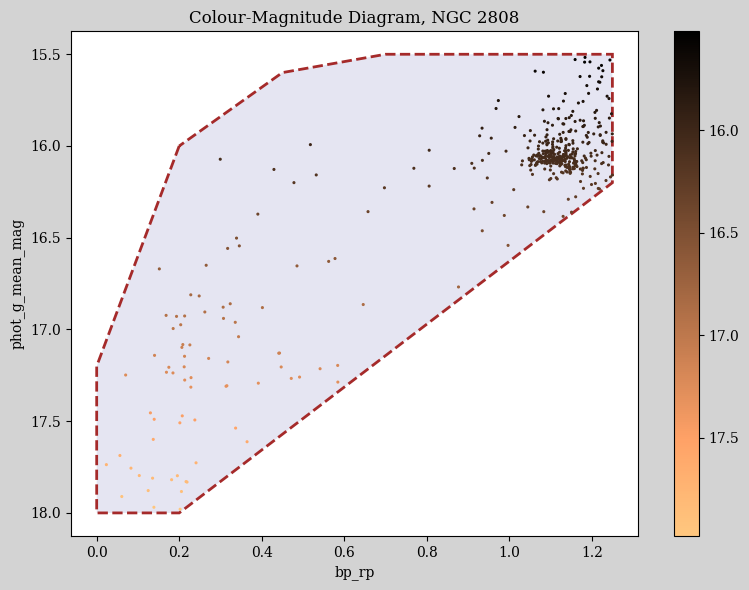

In [143]:
fig, ax = plt.subplots(figsize=(8, 6))

ngc_2808_polygon = plt.Polygon([(0.2, 16), (-0.0, 17.2), (-0.0, 18), (0.2, 18), (1.25, 16.2), (1.25, 15.5), (0.7, 15.5), (0.45, 15.6)],
                               edgecolor='none', facecolor='navy', lw=2, alpha=0.1, ls='--')

ngc_2808_polygon_2 = plt.Polygon([(0.2, 16), (-0.0, 17.2), (-0.0, 18), (0.2, 18), (1.25, 16.2), (1.25, 15.5), (0.7, 15.5), (0.45, 15.6)],
                                 edgecolor='brown', facecolor='none', lw=2, ls='--')


ax.add_patch(ngc_2808_polygon)
ax.add_patch(ngc_2808_polygon_2)

sc = ax.scatter(ngc_2808_clipped_hb['bp_rp'], ngc_2808_clipped_hb['phot_g_mean_mag'], s=1.5, c=ngc_2808_clipped_hb['phot_g_mean_mag'], cmap='copper')
ax.set_xlabel('bp_rp')
ax.set_ylabel('phot_g_mean_mag')
ax.set_title('Colour-Magnitude Diagram, NGC 2808')
ax.invert_yaxis()

cbar = fig.colorbar(sc)
cbar.ax.invert_yaxis()

plt.tight_layout()


Una vez filtrados los datos para la rama horizontal, podemos calcular estadísticas descriptivas sobre la columna de magnitud aparente, para conocer su promedio y su desviación estándar.

In [144]:
descriptive_stats_g_mag = ngc_2808_clipped_hb['phot_g_mean_mag'].describe()

# display mean plus minus 1 sigma in latex format
mean = descriptive_stats_g_mag['mean']
std = descriptive_stats_g_mag['std']

print('Magnitud aparente promedio de la secuencia principal: {:.3} ± {:.1} mag'.format(mean, std))


Magnitud aparente promedio de la secuencia principal: 16.2 ± 0.5 mag


Ahora, conociendo la relación entre magnitud aparente, absoluta y distancia:

$$m - M = 5 \cdot \log_{10}\left(\frac{d}{10\hspace{1mm}\text{pc}}\right)$$

Y, operando bajo la suposición de que todas las estrellas que se encuentren en la rama horizontal de cualquier cúmulo poseen propiedades muy similares, lo cual hace que su magnitud absoluta sea cercana a equivalente, podemos estimar la distancia al cúmulo NGC 2808 utilizando la magnitud absoluta de la rama horizontal, que calculamos para NGC 5904 y que es de $0.8 \pm 0.4$ mag, y la magnitud aparente de la rama horizontal de NGC 2808, a través de la fórmula:

$$d = 10^{\frac{m - M + 5}{5}} \hspace{1mm}\text{pc}$$

In [146]:
def distance(app_mag):
    exponent = (app_mag - 0.8 + 5) / 5
    return 10 ** exponent

ngc_2808_clipped_hb['est_distance'] = distance(ngc_2808_clipped_hb['phot_g_mean_mag'])
ngc_2808_clipped_hb['est_distance'].describe()

count      452.000000
mean     12508.850589
std       3544.414782
min       8778.065154
25%      10977.584449
50%      11333.172530
75%      11710.730968
max      27287.779684
Name: est_distance, dtype: float64

A través de estos cálculos, estimamos que la distancia al cúmulo NGC 2808 es de $12.508 \pm 3.544$ kpc.

### $\text{e)}$

La columna 'parallax' de GAIA provee el ángulo que subtiende una estrella en el cielo en miliarcosegundos.

In [147]:
ngc_2808_clipped['parallax']

34       0.869221
615      0.305698
760      0.710377
813      0.052341
1427     0.025284
           ...   
44764    0.405753
45929    0.392825
46067    0.498717
46283    0.043441
46394    0.362253
Name: parallax, Length: 1985, dtype: float64

Podemos entonces utilizar estos datos para estimar la distancia al cúmulo por paralaje, utilizando la sencilla relación trigonométrica:

$$D = \frac{1 \hspace{1mm} \text{pc}}{\tan(p)} \approx \frac{1\hspace{1mm} \text{pc}}{p}$$

donde D es la distancia en parsec, y p el paralaje en arcosegundos.

In [148]:
def parallax_to_distance(parallax):
    # Convertir miliarcosegundos a arcosegundos
    parallax = parallax / 1000
    return 1 / parallax

ngc_2808_clipped['parallax_distance'] = parallax_to_distance(ngc_2808_clipped['parallax'])
ngc_2808_clipped['parallax_distance'].describe()

count    1.985000e+03
mean     5.870748e+03
std      1.279061e+05
min     -3.439985e+06
25%      4.769768e+03
50%      9.513931e+03
75%      1.489306e+04
max      1.019584e+06
Name: parallax_distance, dtype: float64

Notamos que la desviación estándar de estos datos es muy alta, con outliers hasta tres órdenes de magnitud por encima del promedio. Para poder comparar representativamente los datos, eliminaremos los outliers que se encuentren a más o menos 0.5 desviaciones estándar.

In [152]:
std = ngc_2808_clipped['parallax_distance'].std()
ngc_2808_clipped['parallax_distance'] = ngc_2808_clipped['parallax_distance'][(ngc_2808_clipped['parallax_distance'] > ngc_2808_clipped['parallax_distance'].mean() - std/2) &
                                                                              (ngc_2808_clipped['parallax_distance'] < ngc_2808_clipped['parallax_distance'].mean() + std/2)]

In [153]:
ngc_2808_clipped['parallax_distance'].describe()

count     1216.000000
mean      9252.647198
std       3489.715493
min       2821.726915
25%       6374.695366
50%       9214.442250
75%      11823.521134
max      16624.109500
Name: parallax_distance, dtype: float64

In [155]:
ngc_2808_clipped_hb['est_distance'].mean() - ngc_2808_clipped['parallax_distance'].mean()

3256.203390470331

In [154]:
percentage_diff = (ngc_2808_clipped['parallax_distance'].mean() - ngc_2808_clipped_hb['est_distance'].mean()) / ngc_2808_clipped_hb['est_distance'].mean() * 100
percentage_diff

-26.03119581155645

A través de la rama horizontal, estimamos una distancia al cúmulo promedio de $12.508$ kpc, lo cual constituye una diferencia de unos $\sim 3.256$ kpc, es decir, una discrepancia del 26%.

## $\text{Problema 2: Constante de Hubble}$

### $\text{a)}$

Las supernovas de tipo IA varían de forma muy pequeña y de manera muy sistemática, por lo que son muy útiles como candelas estándar. Estas supernovas son muy consistentes en su producción de energía, y cuando llegan a su brillo máximo típicamente llegan en promedio a una magnitud máxima en la banda B y óptica de $-19.3 \pm 0.03$ mag.

El hecho de que las curvas de luz de diferentes supernovas de tipo IA sean tan similares y consistentes, implica que debe existir un proceso o mecanismo muy uniforme que sea responsable de estos eventos. 

La explicación más aceptada actualmente es que estos eventos se deben a la destrucción de una enana blanca en un sistema binario. Una enana blanca puede acumular material de su estrella compañera, lo que puede ocasionar que la masa de la enana blanca llegue al límite de Chandrasekhar, haciendo que se produzca una explosión debido al colapso de ésta (Carroll & Ostlie, 2017, p. 750-751). 

Ya que estamos asumiendo que estas explosiones ocurren cuando una enana blanca llega al límite de Chandrasekhar, tiene sentido que las curvas de luz de diferentes supernovas sean muy similares, ya que siempre deben tener masas cercanas a $1.4\hspace{1mm}M_\odot$, y por lo tanto, deben tener luminosidades similares, debido a la relación masa-luminosidad.

### $\text{b)}$

Queremos encontrar una relación entre el módulo de distancia de una supernova de tipo IA y su redshift. Sabemos que el módulo de distancia $\mu = m - M$ se expresa como:

$$\mu = m - M = 5\log_{10} \left(\frac{d}{10 \hspace{1mm}\text{pc}}\right)$$

A menudo las distancias a supernovas se miden en Mpc, ya que se utilizan para estimar parámetros cosmológicos como la constante de Hubble, cuyas unidades son de $\text{km}\hspace{1mm}\text{s}^{-1}\hspace{1mm}\text{Mpc}^{-1}$. Luego, podemos expresar la ecuación anterior en Mpc, como:

$$\mu= 5\log_{10} \left(\frac{d}{10 \cdot 10^{-6} \hspace{1mm}\text{Mpc}}\right)$$

$$\rightarrow\hspace{2mm} \mu = 5\left[\log_{10} \left(\frac{d}{1\hspace{1mm}\text{Mpc}}\right) - \log_{10}\left(10^{-5}\right)\right]$$

$$\rightarrow\hspace{2mm} \mu = 5\log_{10} \left(\frac{d}{1\hspace{1mm}\text{Mpc}}\right) + 25$$

Donde $d$ es la distancia en Mpc. Ahora, sabemos que la ley de Hubble describe una relación lineal entre la velocidad a la que se expande el universo a una distancia determinada, dada por

$$v = H_0 \cdot D$$

También, la velocidad de expansión (no relativista, a bajas distancias) puede expresarse en función del redshift como:

$$v = c\cdot z$$

Así, podemos expresar la distancia en función de la constante de Hubble y del redshift, de la forma:

$$D = \frac{cz}{H_0}$$

Reemplazando esta expresión para la distancia en la ecuación del módulo de distancia, encontramos una expresión que relaciona $\mu$ con $z$:

$$\rightarrow\hspace{2mm} \mu = 5\log_{10} \left(\frac{cz}{H_0\hspace{1mm}\text{Mpc}}\right) + 25$$

Haciendo análisis dimensional, vemos que la relación es consistente ya que el módulo de distancia $\mu$ debe ser adimensional:

$$[\mu] = \left[\log_{10} \left(\frac{cz}{H_0\hspace{1mm}\text{Mpc}}\right)\right] = \left[\log_{10} \left(\frac{\cancel{\text{km}\hspace{1mm}\text{s}^{-1}}}{\cancel{\text{km}\hspace{1mm}\text{s}^{-1}}\hspace{1mm}\cancel{\text{Mpc}^{-1}}\hspace{1mm}\cancel{\text{Mpc}}}\right)\right] = \left[\log_{10}\left(\text{dimensionless}\right)\right] = \text{dimensionless}$$

### $\text{c)}$

In [56]:
supernovae_data_1 = pd.read_csv('supernovae_t1.csv', delimiter=';')
supernovae_data_1.head()

,SN,Z,BMAX,D_M15_B
0,90O,0.030,16.32,0.96
1,90T,0.040,17.16,1.15
2,90Y,0.039,17.70,1.13
3,90af,0.050,17.87,1.56
4,91S,0.056,17.81,1.04


In [57]:
M_MAX_B = -19.258

supernovae_data_1['Z'] = supernovae_data_1['Z'].astype(float)
supernovae_data_1['BMAX'] = supernovae_data_1['BMAX'].astype(float)
supernovae_data_1['D_M15_B'] = supernovae_data_1['D_M15_B'].astype(float)

supernovae_data_1['MU_MAX'] = supernovae_data_1['BMAX'] - M_MAX_B

supernovae_data_1.head()

,SN,Z,BMAX,D_M15_B,MU_MAX
0,90O,0.030,16.32,0.96,35.578
1,90T,0.040,17.16,1.15,36.418
2,90Y,0.039,17.70,1.13,36.958
3,90af,0.050,17.87,1.56,37.128
4,91S,0.056,17.81,1.04,37.068


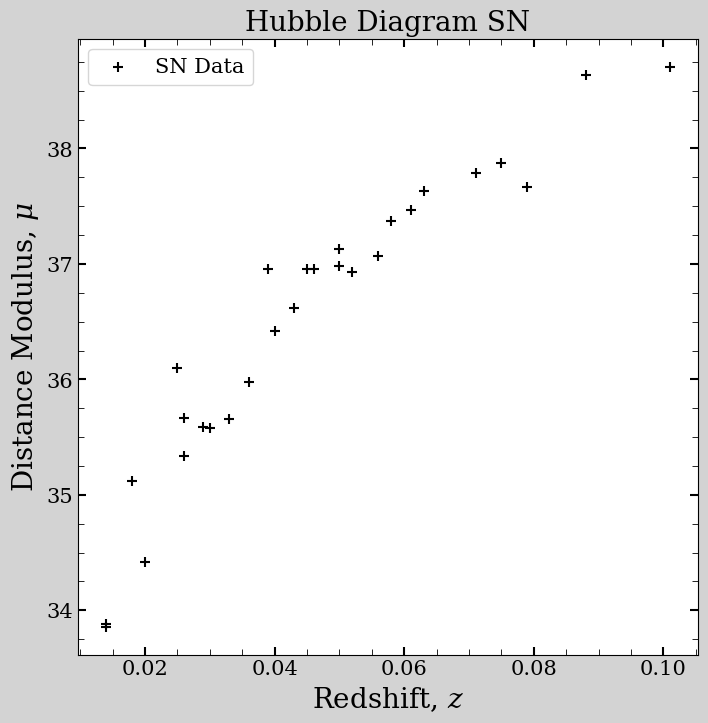

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(supernovae_data_1['Z'], supernovae_data_1['MU_MAX'], s=45, color='black', label='SN Data', marker='+')

ax.set_ylabel(r'Distance Modulus, $\mu$', fontsize=20)
ax.set_xlabel(r"Redshift, $z$", fontsize=20)
ax.set_title(r'Hubble Diagram SN', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(0.005))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.grid(False, which='both')
ax.legend(fontsize=15, markerscale=1)

### $\text{d)}$

In [59]:
def modulus_redshift(z, H0):
    c = const.c.to(u.km / u.s).value
    return 5 * np.log10((z * c) / H0) + 25

In [60]:
popt, pcov = curve_fit(modulus_redshift, supernovae_data_1['Z'], supernovae_data_1['MU_MAX'])

H0 = popt[0]
H0_err = np.sqrt(np.diag(pcov))[0]

print('Constante de Hubble H0 = {:.2f} ± {:.2f} km/s/Mpc'.format(H0, H0_err))

Constante de Hubble H0 = 60.56 ± 1.53 km/s/Mpc


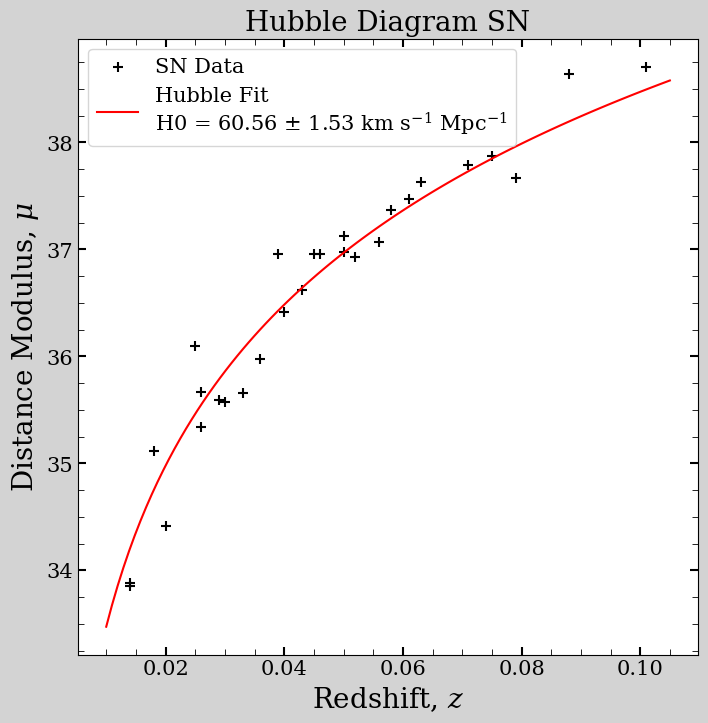

In [69]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(supernovae_data_1['Z'], supernovae_data_1['MU_MAX'], s=45, color='black', label='SN Data', marker='+')
ax.plot(np.linspace(0.01, 0.105, 100), modulus_redshift(np.linspace(0.01, 0.105, 100), H0), color='red',
        label='Hubble Fit\n'+r'H0 = {:.2f} ± {:.2f} '.format(H0, H0_err) + 'km s$^{-1}$ Mpc$^{-1}$')

ax.set_ylabel(r'Distance Modulus, $\mu$', fontsize=20)
ax.set_xlabel(r"Redshift, $z$", fontsize=20)
ax.set_title(r'Hubble Diagram SN', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(0.005))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.grid(False, which='both')
ax.legend(fontsize=15, markerscale=1)

### $\text{e)}$

In [70]:
def calibrated_bmax(dm15):
    return M_MAX_B + 0.78 * (dm15 - 1.1)

supernovae_data_1['M_B_MAX_CALIBRATED'] = calibrated_bmax(supernovae_data_1['D_M15_B'])
supernovae_data_1['MU_MAX_CALIBRATED'] = supernovae_data_1['BMAX'] - supernovae_data_1['M_B_MAX_CALIBRATED']
supernovae_data_1.head()

,SN,Z,BMAX,D_M15_B,MU_MAX,M_B_MAX_CALIBRATED,MU_MAX_CALIBRATED
0,90O,0.030,16.32,0.96,35.578,-19.3672,35.6872
1,90T,0.040,17.16,1.15,36.418,-19.2190,36.3790
2,90Y,0.039,17.70,1.13,36.958,-19.2346,36.9346
3,90af,0.050,17.87,1.56,37.128,-18.8992,36.7692
4,91S,0.056,17.81,1.04,37.068,-19.3048,37.1148


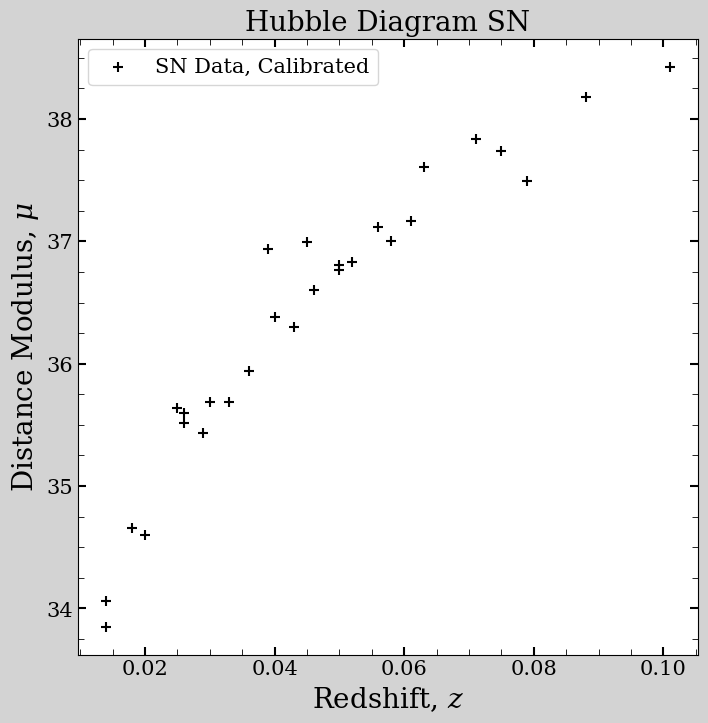

In [71]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(supernovae_data_1['Z'], supernovae_data_1['MU_MAX_CALIBRATED'], s=45, color='black', label='SN Data, Calibrated', marker='+')

ax.set_ylabel(r'Distance Modulus, $\mu$', fontsize=20)
ax.set_xlabel(r"Redshift, $z$", fontsize=20)
ax.set_title(r'Hubble Diagram SN', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(0.005))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.grid(False, which='both')
ax.legend(fontsize=15, markerscale=1)

### $\text{f)}$

In [72]:
popt, pcov = curve_fit(modulus_redshift, supernovae_data_1['Z'], supernovae_data_1['MU_MAX_CALIBRATED'])

H0 = popt[0]
H0_err = np.sqrt(np.diag(pcov))[0]

print('Constante de Hubble H0 = {:.2f} ± {:.2f} km/s/Mpc'.format(H0, H0_err))

Constante de Hubble H0 = 64.14 ± 1.23 km/s/Mpc


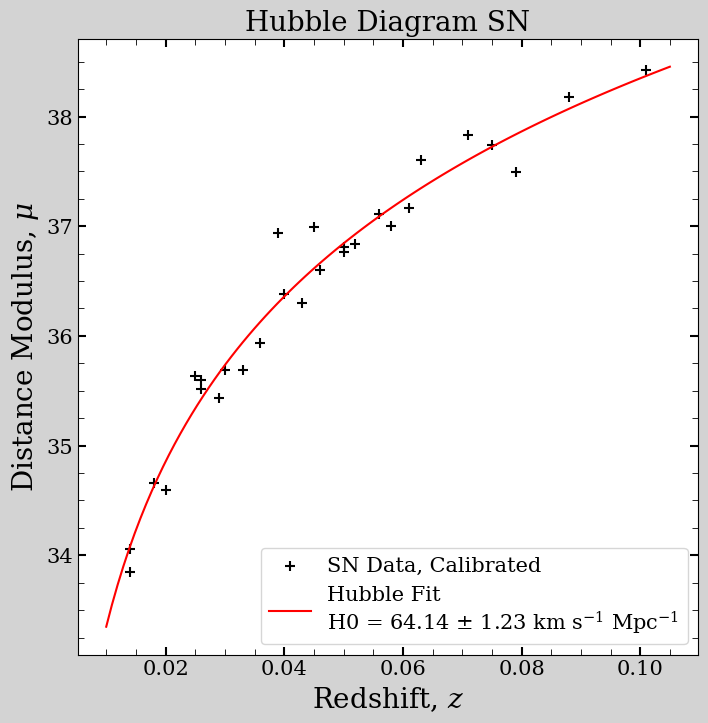

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(supernovae_data_1['Z'], supernovae_data_1['MU_MAX_CALIBRATED'], s=45, color='black', label='SN Data, Calibrated', marker='+')
ax.plot(np.linspace(0.01, 0.105, 100), modulus_redshift(np.linspace(0.01, 0.105, 100), H0), color='red',
        label='Hubble Fit\n'+r'H0 = {:.2f} ± {:.2f} '.format(H0, H0_err) + 'km s$^{-1}$ Mpc$^{-1}$')

ax.set_ylabel(r'Distance Modulus, $\mu$', fontsize=20)
ax.set_xlabel(r"Redshift, $z$", fontsize=20)
ax.set_title(r'Hubble Diagram SN', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(0.005))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.grid(False, which='both')
ax.legend(fontsize=15, markerscale=1)

### $\text{g)}$

In [74]:
supernovae_data_t2 = pd.read_csv('supernovae_t2.csv', delimiter=';')
supernovae_data_t2.head()

,SN,z,BMAX,Δm15(B)
0,1996c,0.828,24.58,1.19
1,1997G,0.763,24.49,1.07
2,1997ap,0.830,24.30,1.13


In [75]:
supernovae_data_t2['M_B_MAX_CALIBRATED'] = calibrated_bmax(supernovae_data_t2['Δm15(B)'])
supernovae_data_t2['MU_MAX_CALIBRATED'] = supernovae_data_t2['BMAX'] - supernovae_data_t2['M_B_MAX_CALIBRATED']
supernovae_data_t2.head()

,SN,z,BMAX,Δm15(B),M_B_MAX_CALIBRATED,MU_MAX_CALIBRATED
0,1996c,0.828,24.58,1.19,-19.1878,43.7678
1,1997G,0.763,24.49,1.07,-19.2814,43.7714
2,1997ap,0.830,24.30,1.13,-19.2346,43.5346


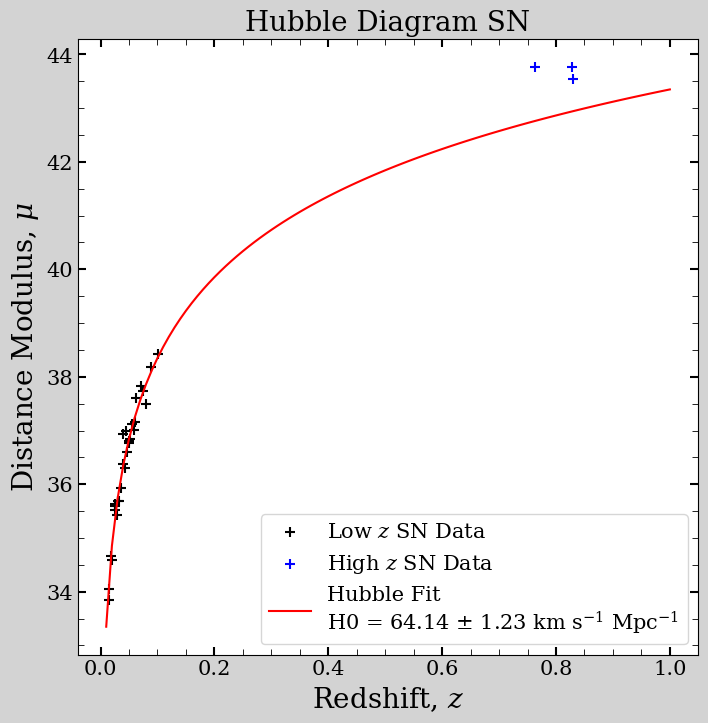

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(supernovae_data_1['Z'], supernovae_data_1['MU_MAX_CALIBRATED'], s=45, color='black', label=r'Low $z$ SN Data', marker='+')
ax.scatter(supernovae_data_t2['z'], supernovae_data_t2['MU_MAX_CALIBRATED'], s=45, color='blue', label=r'High $z$ SN Data', marker='+')
ax.plot(np.linspace(0.01, 1, 100), modulus_redshift(np.linspace(0.01, 1, 100), H0), color='red',
        label='Hubble Fit\n'+r'H0 = {:.2f} ± {:.2f} '.format(H0, H0_err) + 'km s$^{-1}$ Mpc$^{-1}$')

ax.set_ylabel(r'Distance Modulus, $\mu$', fontsize=20)
ax.set_xlabel(r"Redshift, $z$", fontsize=20)
ax.set_title(r'Hubble Diagram SN', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.grid(False, which='both')
ax.legend(fontsize=15, markerscale=1)

## $\text{Bibliografía}$

- $\text{Carroll, B. W., \& Ostlie, D. A. (2017). An Introduction to Modern Astrophysics. Cambridge University Press.}$